# Convolutional Neural Networks

Up until transformers, convolutions were *the* state of the art in computer vision.  In many ways and applications they still are!

Large Language Models, which are what we'll focus on the rest of the series after this lecture, are really good at ordered, *tokenized data.  But there is lots of data that isn't _implicitly_ ordered like `images`, and their more general cousins `graphs`.

Today's lecture focuses on computer vision models, and particularly on convolutional neural networks.  There are a ton of applications you can do with these, and not nearly enough time to get into them.  Check out the extra references file to see some publications to get you started if you want to learn more.


## Convolutional Networks: A brief historical context

![ImageNet Accuracy by Yearh](ImageNet.png)

[reference](https://www.researchgate.net/publication/332452649_A_Roadmap_for_Foundational_Research_on_Artificial_Intelligence_in_Medical_Imaging_From_the_2018_NIHRSNAACRThe_Academy_Workshop)

In [1]:
import torch, torchvision

# Convolutional Building Blocks

We're going to go through some examples of building blocks for convolutional networks.  To help illustate some of these, let's use an image for examples:


In [2]:
from PIL import Image
alcf_image = Image.open("ALCF-Staff.jpg")

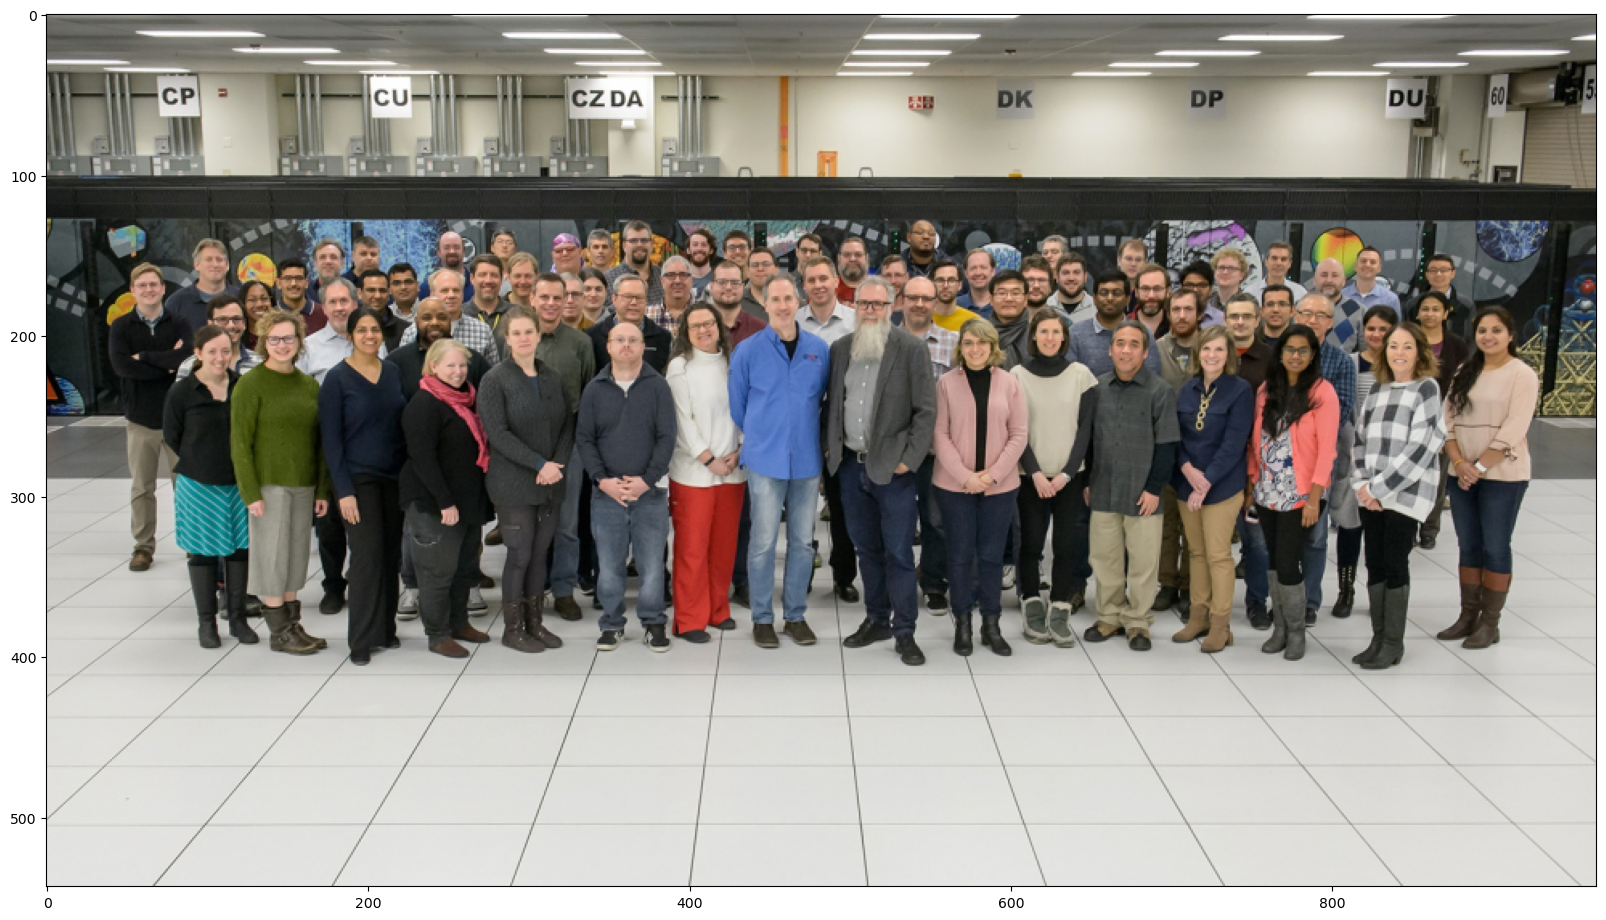

In [3]:
from matplotlib import pyplot as plt
figure = plt.figure(figsize=(20,20))
plt.imshow(alcf_image)
plt.show()

## Convolutions

Convolutions are a restriction of - and a specialization of - dense linear layers.  A convolution of an image produces another image, and each output pixel is a function of only it's local neighborhood of points.  This is called an _inductive bias_ and is a big reason why convolutions work for image data: neighboring pixels are correlated and you can operate on just those pixels at a time.

See examples of convolutions [here](https://github.com/vdumoulin/conv_arithmetic)

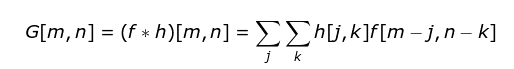

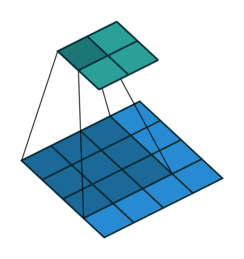


torch.Size([1, 3, 529, 951])
torch.Size([1, 3, 543, 965])


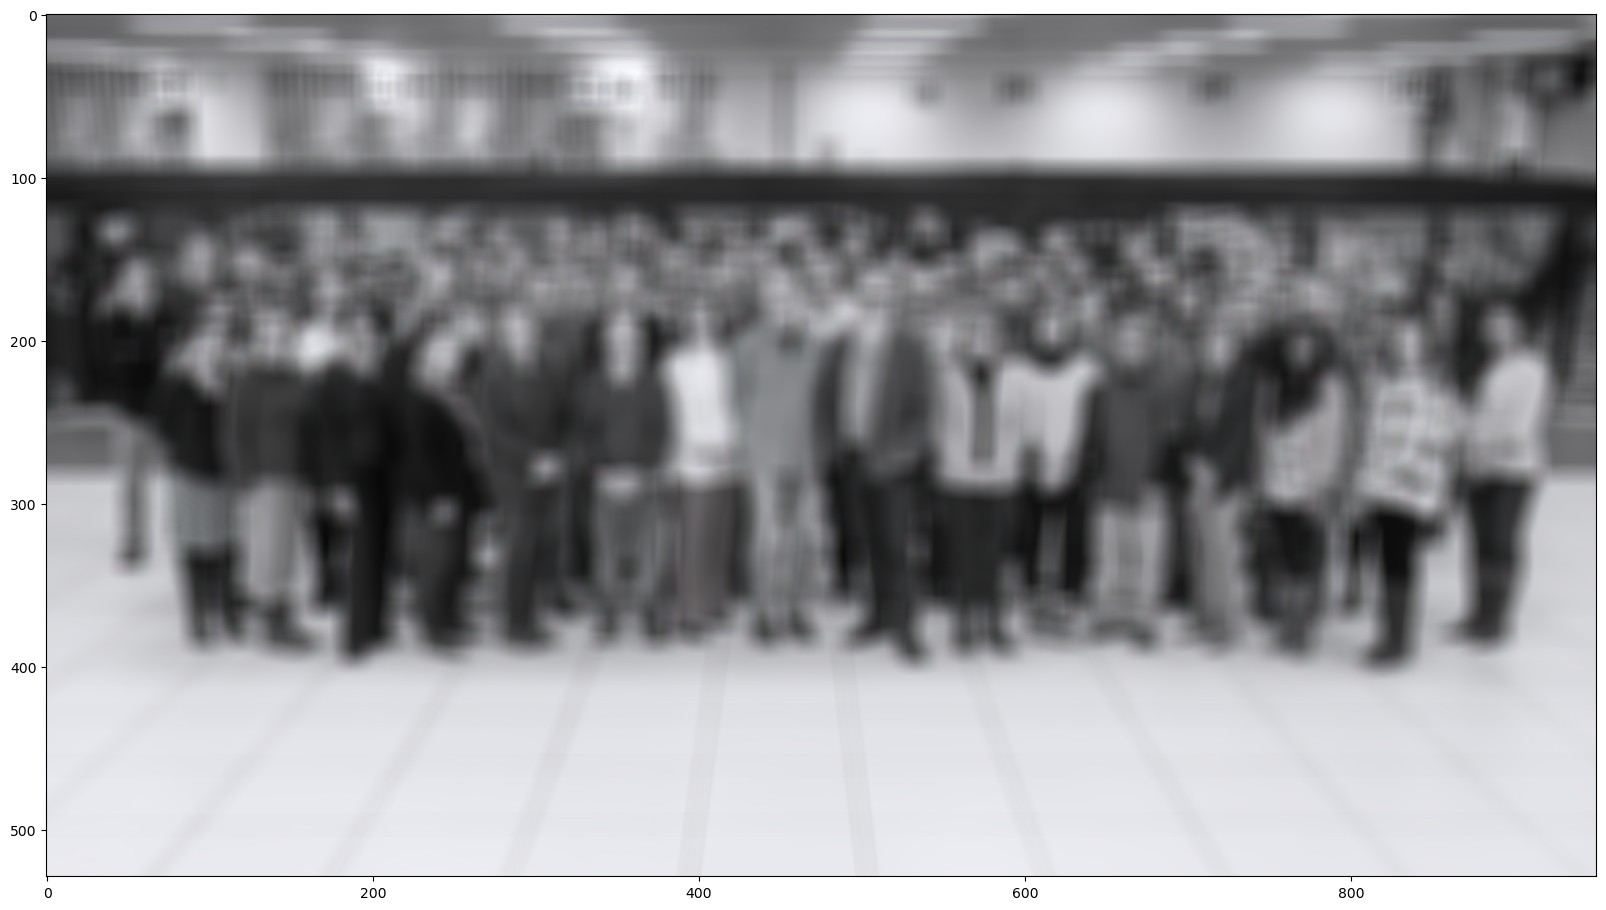

In [4]:
# Let's apply a convolution to the ALCF Staff photo:
alcf_tensor = torchvision.transforms.ToTensor()(alcf_image)

# Reshape the tensor to have a batch size of 1:
alcf_tensor = alcf_tensor.reshape((1,) + alcf_tensor.shape)

# Create a random convolution:
# shape is: (channels_in, channels_out, kernel_x, kernel_y)
conv_random = torch.rand((3,3,15,15))

alcf_rand = torch.nn.functional.conv2d(alcf_tensor, conv_random)
alcf_rand = (1./alcf_rand.max()) * alcf_rand
print(alcf_rand.shape)
alcf_rand = alcf_rand.reshape(alcf_rand.shape[1:])

print(alcf_tensor.shape)

rand_image = alcf_rand.permute((1,2,0)).cpu()

figure = plt.figure(figsize=(20,20))

plt.imshow(rand_image)


## Normalization

![Batch Norm](batch_norm.png)
Reference: [Normalizations](https://arxiv.org/pdf/1903.10520.pdf)

Normalization is the act of transforming the mean and moment of your data to standard values (usually 0.0 and 1.0).  It's particularly useful in machine learning since it stabilizes training, and allows higher learning rates.

![Batch Normalization accelerates training](batch_norm_effect.png)

Reference: [Batch Norm](https://arxiv.org/pdf/1502.03167.pdf)


torch.Size([1, 3, 543, 965])


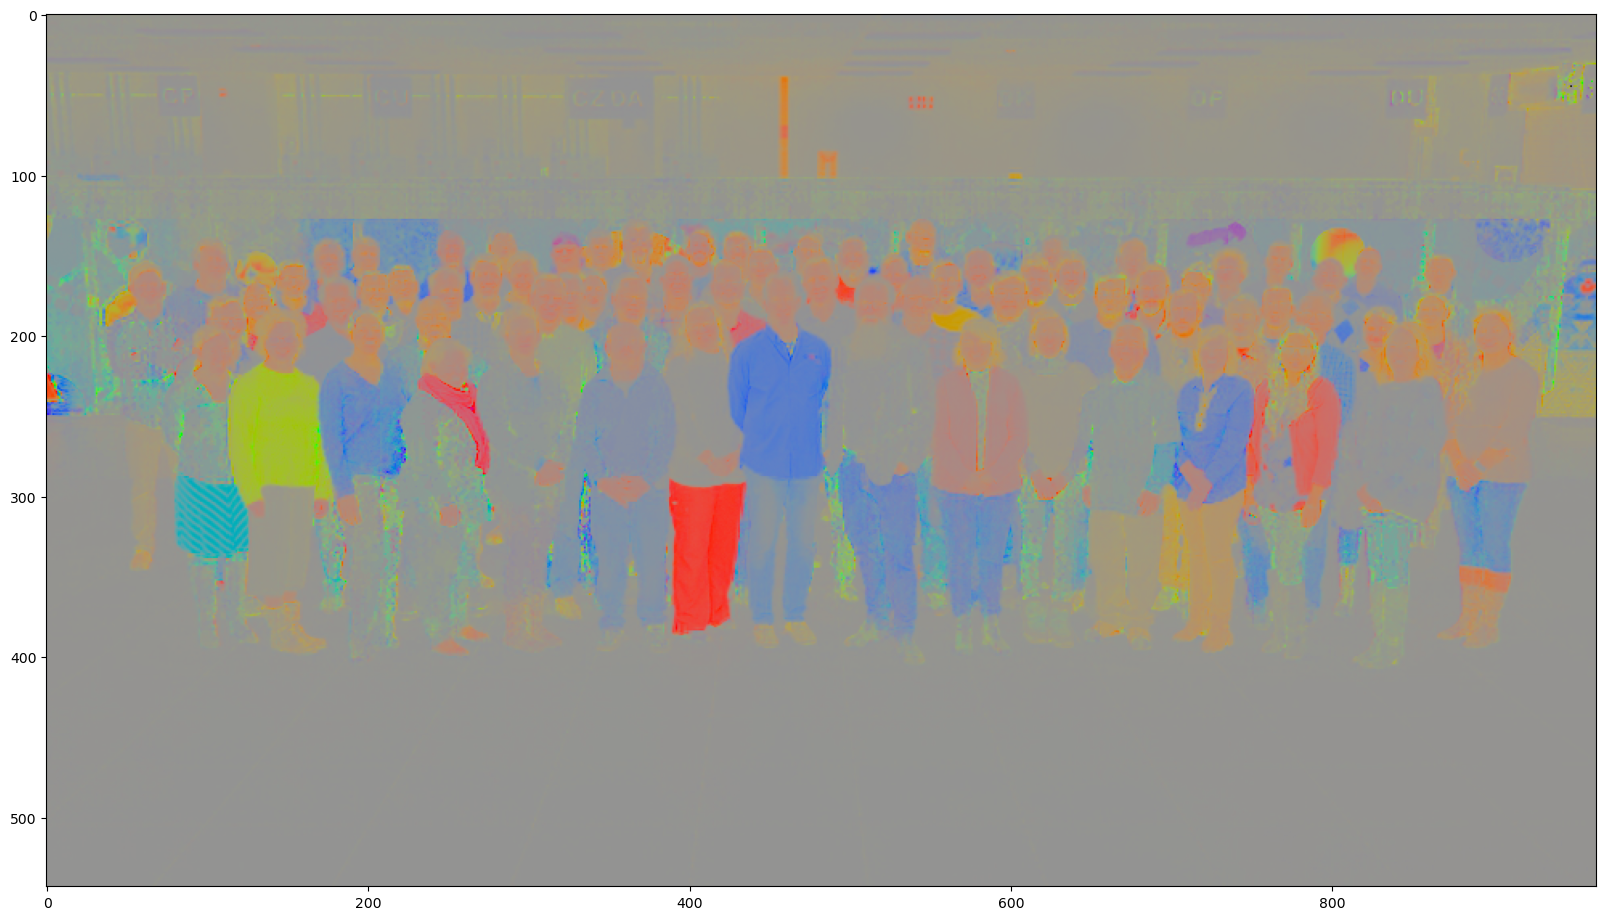

In [5]:
# Let's apply a normalization to the ALCF Staff photo:
alcf_tensor = torchvision.transforms.ToTensor()(alcf_image)

# Reshape the tensor to have a batch size of 1:
alcf_tensor = alcf_tensor.reshape((1,) + alcf_tensor.shape)


alcf_rand = torch.nn.functional.normalize(alcf_tensor)
alcf_rand = alcf_rand.reshape(alcf_rand.shape[1:])

print(alcf_tensor.shape)

rand_image = alcf_rand.permute((1,2,0)).cpu()

figure = plt.figure(figsize=(20,20))

plt.imshow(rand_image)



## Downsampling (And upsampling)

Downsampling is a critical component of convolutional and many vision models.  Because of the local-only nature of convolutional filters, learning large-range features can be too slow for convergence.  Downsampling of layers can bring information from far away closer, effectively changing what it means to be "local" as the input to a convolution.

![Convolutional Pooling](conv_pooling.png "Pooling")

[Reference](https://www.researchgate.net/publication/333593451_Application_of_Transfer_Learning_Using_Convolutional_Neural_Network_Method_for_Early_Detection_of_Terry's_Nail)



torch.Size([1, 3, 543, 965])


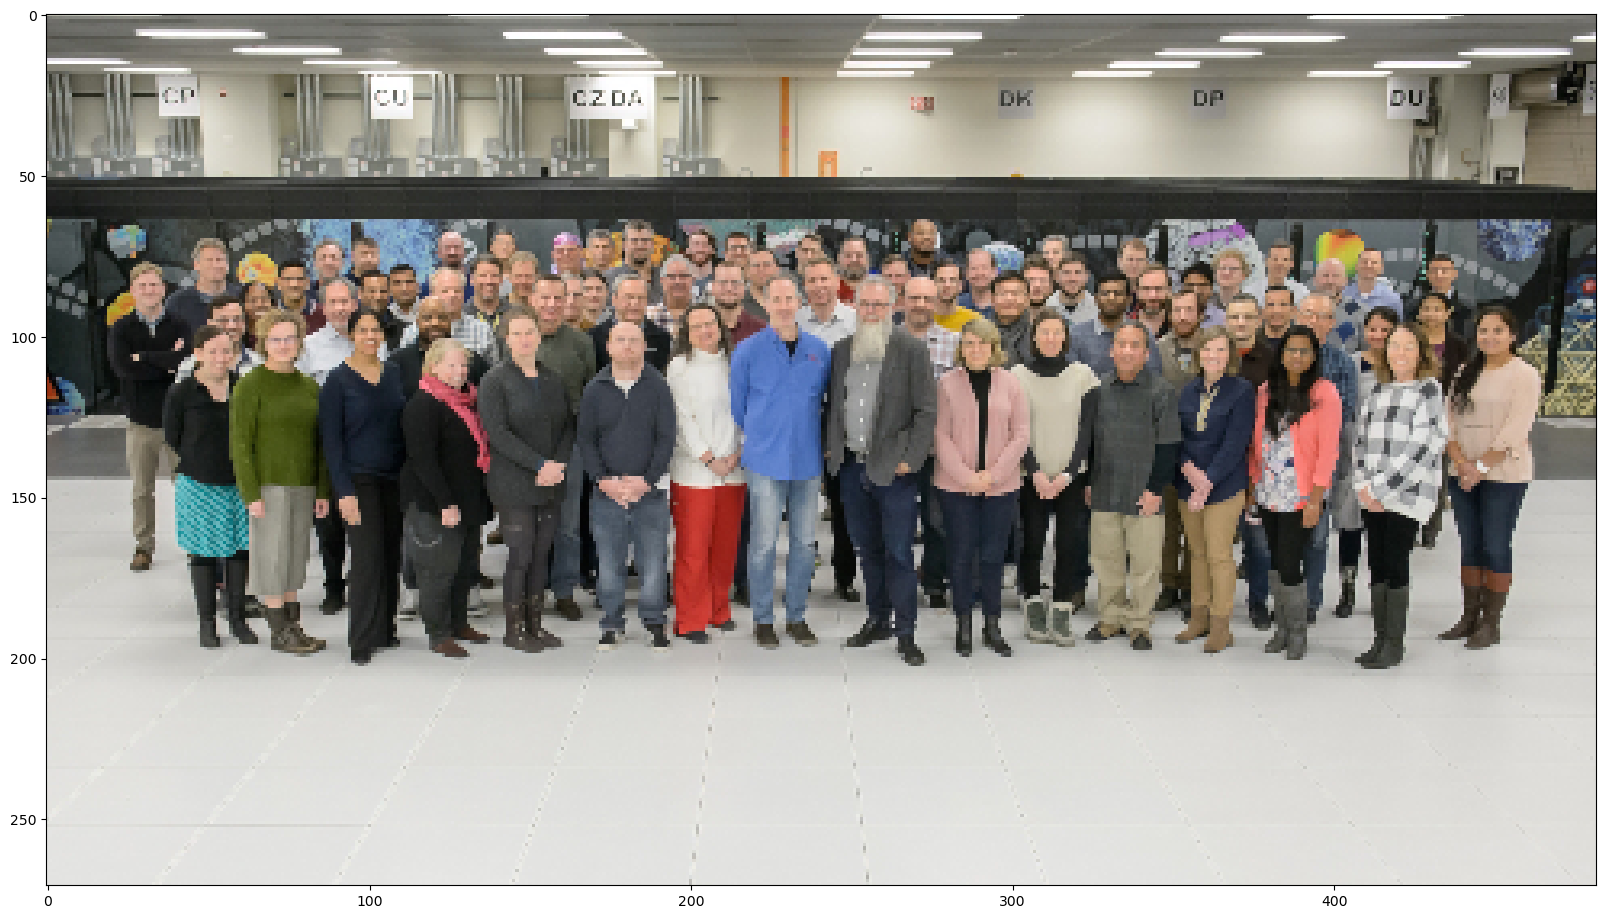

In [6]:
# Let's apply a normalization to the ALCF Staff photo:
alcf_tensor = torchvision.transforms.ToTensor()(alcf_image)

# Reshape the tensor to have a batch size of 1:
alcf_tensor = alcf_tensor.reshape((1,) + alcf_tensor.shape)


alcf_rand = torch.nn.functional.max_pool2d(alcf_tensor, 2)
alcf_rand = alcf_rand.reshape(alcf_rand.shape[1:])

print(alcf_tensor.shape)

rand_image = alcf_rand.permute((1,2,0)).cpu()

figure = plt.figure(figsize=(20,20))

plt.imshow(rand_image)


## Residual Connections

One issue, quickly encountered when making convolutional networks deeper and deeper, is the "Vanishing Gradients" problem.  As layers were stacked on top of each other, the size of updates dimished at the earlier layers of a convolutional network.  The paper "Deep Residual Learning for Image Recognition" solved this by introduction "residual connections" as skip layers.


Reference: [Deep Residual Learning for Image Recognition](https://arxiv.org/pdf/1512.03385.pdf)

![Residual Layer](residual_layer.png)


Compare the performance of the models before and after the introduction of these layers:

![Resnet Performance vs. Plain network performance](resnet_comparison.png)

If you have time to read only one paper on computer vision, make it this one!  Resnet was the first model to beat human accuracy on ImageNet and is one of the most impactful papers in AI ever published.

# Building a ConvNet

In this section we'll build and apply a conv net to the mnist dataset.  The layers here are loosely based off of the ConvNext architecture.  Why?  Because we're getting into LLM's soon, and this ConvNet uses LLM features.  ConvNext is an update to the ResNet architecture that outperforms it.

[ConvNext](https://arxiv.org/abs/2201.03545)


The dataset here is CIFAR-10 - slightly harder than MNIST but still relatively easy and computationally tractable.

In [7]:
from torchvision.transforms import v2
training_data = torchvision.datasets.CIFAR10(
    root="/home/gridsan/amenon/am2145_ai-science-training-series_HW3/datasets/CIFAR-10/",
    train=True,
    download=False,
    transform=v2.Compose([
        v2.ToTensor(),
        v2.RandomHorizontalFlip(),
        v2.RandomResizedCrop(size=32, scale=[0.85,1.0], antialias=False),
        v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    ])
)

test_data = torchvision.datasets.CIFAR10(
    root="/home/gridsan/amenon/am2145_ai-science-training-series_HW3/datasets/CIFAR-10/",
    train=False,
    download=False,
    transform=torchvision.transforms.ToTensor()
)

training_data, validation_data = torch.utils.data.random_split(training_data, [0.8, 0.2], generator=torch.Generator().manual_seed(55))

batch_size = 128

# The dataloader makes our dataset iterable 
train_dataloader = torch.utils.data.DataLoader(training_data, 
    batch_size=batch_size, 
    pin_memory=True,
    shuffle=True, 
    num_workers=4)
val_dataloader = torch.utils.data.DataLoader(validation_data, 
    batch_size=batch_size, 
    pin_memory=True,
    shuffle=False, 
    num_workers=4)

/home/gridsan/amenon/miniforge3/envs/basf_chemprop/lib/python3.11/site-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [8]:
from matplotlib import pyplot as plt
%matplotlib inline

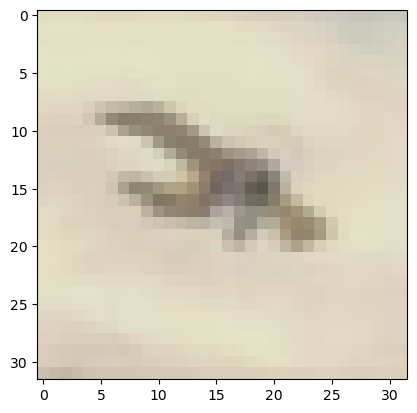

In [9]:
batch, (X, Y) = next(enumerate(train_dataloader))
plt.imshow(X[0].cpu().permute((1,2,0))); plt.show()

This code below is important as our models get bigger: this is wrapping the pytorch data loaders to put the data onto the GPU!

In [10]:
dev = torch.device(
    "cuda") if torch.cuda.is_available() else torch.device("cpu")


def preprocess(x, y):
    # CIFAR-10 is *color* images so 3 layers!
    return x.view(-1, 3, 32, 32).to(dev), y.to(dev)


class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        for b in self.dl:
            yield (self.func(*b))


train_dataloader = WrappedDataLoader(train_dataloader, preprocess)
val_dataloader = WrappedDataLoader(val_dataloader, preprocess)

In [11]:
print(dev)

cuda


In [36]:
from torch import nn


class Downsampler(nn.Module):

    def __init__(self, in_channels, out_channels, shape, stride=2):
        super(Downsampler, self).__init__()

        self.norm = nn.LayerNorm([in_channels, *shape])

        self.downsample = nn.Conv2d(
            in_channels=in_channels, 
            out_channels=out_channels,
            kernel_size = stride,
            stride = stride,
        )
    
    def forward(self, inputs):


        return self.downsample(self.norm(inputs))
        
        

class ConvNextBlock(nn.Module):
    """This block of operations is loosely based on this paper:

    """


    def __init__(self, in_channels, shape):
        super(ConvNextBlock, self).__init__()

        # Depthwise, seperable convolution with a large number of output filters:
        self.conv1 = nn.Conv2d(in_channels=in_channels, 
                                     out_channels=in_channels, 
                                     groups=in_channels,
                                     kernel_size=[7,7],
                                     padding='same' )

        self.norm = nn.LayerNorm([in_channels, *shape])

        # Two more convolutions:
        self.conv2 = nn.Conv2d(in_channels=in_channels, 
                                     out_channels=4*in_channels,
                                     kernel_size=1)

        self.conv3 = nn.Conv2d(in_channels=4*in_channels, 
                                     out_channels=in_channels,
                                     kernel_size=1
                                     )


    def forward(self, inputs):
        x = self.conv1(inputs)

        # The normalization layer:
        x = self.norm(x)

        x = self.conv2(x)

        # The non-linear activation layer:
        x = torch.nn.functional.gelu(x)

        x = self.conv3(x)

        # This makes it a residual network:
        return x + inputs
    

class Classifier(nn.Module):


    def __init__(self, n_initial_filters, n_stages, blocks_per_stage):
        super(Classifier, self).__init__()

        # This is a downsampling convolution that will produce patches of output.

        # This is similar to what vision transformers do to tokenize the images.
        self.stem = nn.Conv2d(in_channels=3,
                                    out_channels=n_initial_filters,
                                    kernel_size=1,
                                    stride=1)
        
        current_shape = [32, 32]

        self.norm1 = nn.LayerNorm([n_initial_filters,*current_shape])
        # self.norm1 = WrappedLayerNorm()

        current_n_filters = n_initial_filters
        
        self.layers = nn.Sequential()
        for i, n_blocks in enumerate(range(n_stages)):
            # Add a convnext block series:
            for _ in range(blocks_per_stage):
                self.layers.append(ConvNextBlock(in_channels=current_n_filters, shape=current_shape))
            # Add a downsampling layer:
            if i != n_stages - 1:
                # Skip downsampling if it's the last layer!
                self.layers.append(Downsampler(
                    in_channels=current_n_filters, 
                    out_channels=2*current_n_filters,
                    shape = current_shape,
                    )
                )
                # Double the number of filters:
                current_n_filters = 2*current_n_filters
                # Cut the shape in half:
                current_shape = [ cs // 2 for cs in current_shape]
            


        self.head = nn.Sequential(
            nn.Flatten(),
            nn.LayerNorm(current_n_filters),
            nn.Linear(current_n_filters, 10)
        )
        # self.norm2 = nn.InstanceNorm2d(current_n_filters)
        # # This brings it down to one channel / class
        # self.bottleneck = nn.Conv2d(in_channels=current_n_filters, out_channels=10, 
        #                                   kernel_size=1, stride=1)

    def forward(self, inputs):

        x = self.stem(inputs)
        # Apply a normalization after the initial patching:
        x = self.norm1(x)

        # Apply the main chunk of the network:
        x = self.layers(x)

        # Normalize and readout:
        x = nn.functional.avg_pool2d(x, x.shape[2:])
        x = self.head(x)

        return x



        # x = self.norm2(x)
        # x = self.bottleneck(x)

        # # Average pooling of the remaining spatial dimensions (and reshape) makes this label-like:
        # return nn.functional.avg_pool2d(x, kernel_size=x.shape[-2:]).reshape((-1,10))

In [13]:
model = Classifier(64, 4, 2)

model.cuda()

from torchinfo import summary

print(summary(model, input_size=(batch_size, 3, 32, 32)))


Layer (type:depth-idx)                   Output Shape              Param #
Classifier                               [128, 10]                 --
├─Conv2d: 1-1                            [128, 64, 32, 32]         256
├─LayerNorm: 1-2                         [128, 64, 32, 32]         131,072
├─Sequential: 1-3                        [128, 512, 4, 4]          --
│    └─ConvNextBlock: 2-1                [128, 64, 32, 32]         --
│    │    └─Conv2d: 3-1                  [128, 64, 32, 32]         3,200
│    │    └─LayerNorm: 3-2               [128, 64, 32, 32]         131,072
│    │    └─Conv2d: 3-3                  [128, 256, 32, 32]        16,640
│    │    └─Conv2d: 3-4                  [128, 64, 32, 32]         16,448
│    └─ConvNextBlock: 2-2                [128, 64, 32, 32]         --
│    │    └─Conv2d: 3-5                  [128, 64, 32, 32]         3,200
│    │    └─LayerNorm: 3-6               [128, 64, 32, 32]         131,072
│    │    └─Conv2d: 3-7                  [128, 256, 32,

In [14]:
def evaluate(dataloader, model, loss_fn, val_bar):
    # Set the model to evaluation mode - some NN pieces behave differently during training
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader)
    num_batches = len(dataloader)
    loss, correct = 0, 0

    # We can save computation and memory by not calculating gradients here - we aren't optimizing 
    with torch.no_grad():
        # loop over all of the batches
        for X, y in dataloader:

            pred = model(X)
            loss += loss_fn(pred, y).item()
            # how many are correct in this batch? Tracking for accuracy 
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            val_bar.update()
            
    loss /= num_batches
    correct /= (size*batch_size)
    
    accuracy = 100*correct
    return accuracy, loss

In [15]:
def train_one_epoch(dataloader, model, loss_fn, optimizer, progress_bar):
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # forward pass
        pred = model(X)
        loss = loss_fn(pred, y)
        
        # backward pass calculates gradients
        loss.backward()
        
        # take one step with these gradients
        optimizer.step()
        
        # resets the gradients 
        optimizer.zero_grad()      

        progress_bar.update()

In [16]:

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)

In [17]:
from tqdm import tqdm


epochs = 30
for j in range(epochs):
    with tqdm(total=len(train_dataloader), position=0, leave=True, desc=f"Train Epoch {j}") as train_bar:
        train_one_epoch(train_dataloader, model, loss_fn, optimizer, train_bar)
    
    # checking on the training loss and accuracy once per epoch
        
    with tqdm(total=len(train_dataloader), position=0, leave=True, desc=f"Validate (train) Epoch {j}") as train_eval:
        acc, loss = evaluate(train_dataloader, model, loss_fn, train_eval)

        print(f"Epoch {j}: training loss: {loss:.3f}, accuracy: {acc:.3f}")
    with tqdm(total=len(val_dataloader), position=0, leave=True, desc=f"Validate Epoch {j}") as val_bar:
    
        acc_val, loss_val = evaluate(val_dataloader, model, loss_fn, val_bar)
        print(f"Epoch {j}: validation loss: {loss_val:.3f}, accuracy: {acc_val:.3f}")
    

Validate (train) Epoch 0: 100%|██████████| 313/313 [00:08<00:00, 34.80it/s]


Epoch 0: training loss: 1.573, accuracy: 42.846


Validate Epoch 0: 100%|██████████| 79/79 [00:02<00:00, 32.33it/s]


Epoch 0: validation loss: 1.572, accuracy: 42.583


Validate (train) Epoch 1: 100%|██████████| 313/313 [00:06<00:00, 44.94it/s]


Epoch 1: training loss: 1.359, accuracy: 51.530


Validate Epoch 1: 100%|██████████| 79/79 [00:02<00:00, 35.94it/s]


Epoch 1: validation loss: 1.361, accuracy: 51.157


Validate (train) Epoch 2: 100%|██████████| 313/313 [00:07<00:00, 41.11it/s]


Epoch 2: training loss: 1.175, accuracy: 58.921


Validate Epoch 2: 100%|██████████| 79/79 [00:02<00:00, 36.62it/s]


Epoch 2: validation loss: 1.221, accuracy: 56.220


Validate (train) Epoch 3: 100%|██████████| 313/313 [00:06<00:00, 45.42it/s]


Epoch 3: training loss: 1.091, accuracy: 61.676


Validate Epoch 3: 100%|██████████| 79/79 [00:02<00:00, 36.35it/s]


Epoch 3: validation loss: 1.162, accuracy: 59.019


Validate (train) Epoch 4: 100%|██████████| 313/313 [00:07<00:00, 41.44it/s]


Epoch 4: training loss: 0.878, accuracy: 69.040


Validate Epoch 4: 100%|██████████| 79/79 [00:02<00:00, 35.92it/s]


Epoch 4: validation loss: 0.994, accuracy: 64.508


Validate (train) Epoch 5: 100%|██████████| 313/313 [00:07<00:00, 41.21it/s]


Epoch 5: training loss: 0.768, accuracy: 73.068


Validate Epoch 5: 100%|██████████| 79/79 [00:02<00:00, 36.12it/s]


Epoch 5: validation loss: 0.915, accuracy: 66.960


Validate (train) Epoch 6: 100%|██████████| 313/313 [00:07<00:00, 41.25it/s]


Epoch 6: training loss: 0.649, accuracy: 77.429


Validate Epoch 6: 100%|██████████| 79/79 [00:02<00:00, 35.72it/s]


Epoch 6: validation loss: 0.851, accuracy: 70.500


Validate (train) Epoch 7: 100%|██████████| 313/313 [00:07<00:00, 41.15it/s]


Epoch 7: training loss: 0.553, accuracy: 80.683


Validate Epoch 7: 100%|██████████| 79/79 [00:02<00:00, 36.25it/s]


Epoch 7: validation loss: 0.793, accuracy: 71.667


Validate (train) Epoch 8: 100%|██████████| 313/313 [00:07<00:00, 41.44it/s]


Epoch 8: training loss: 0.508, accuracy: 82.156


Validate Epoch 8: 100%|██████████| 79/79 [00:02<00:00, 35.77it/s]


Epoch 8: validation loss: 0.783, accuracy: 72.735


Validate (train) Epoch 9: 100%|██████████| 313/313 [00:07<00:00, 41.03it/s]


Epoch 9: training loss: 0.434, accuracy: 85.066


Validate Epoch 9: 100%|██████████| 79/79 [00:02<00:00, 35.99it/s]


Epoch 9: validation loss: 0.779, accuracy: 73.467


Validate (train) Epoch 10: 100%|██████████| 313/313 [00:07<00:00, 41.59it/s]


Epoch 10: training loss: 0.367, accuracy: 87.420


Validate Epoch 10: 100%|██████████| 79/79 [00:02<00:00, 35.80it/s]


Epoch 10: validation loss: 0.729, accuracy: 74.832


Validate (train) Epoch 11: 100%|██████████| 313/313 [00:07<00:00, 41.82it/s]


Epoch 11: training loss: 0.289, accuracy: 90.221


Validate Epoch 11: 100%|██████████| 79/79 [00:02<00:00, 37.72it/s]


Epoch 11: validation loss: 0.693, accuracy: 76.167


Validate (train) Epoch 12: 100%|██████████| 313/313 [00:07<00:00, 41.17it/s]


Epoch 12: training loss: 0.262, accuracy: 91.029


Validate Epoch 12: 100%|██████████| 79/79 [00:02<00:00, 35.74it/s]


Epoch 12: validation loss: 0.737, accuracy: 76.286


Validate (train) Epoch 13: 100%|██████████| 313/313 [00:07<00:00, 41.10it/s]


Epoch 13: training loss: 0.234, accuracy: 91.995


Validate Epoch 13: 100%|██████████| 79/79 [00:02<00:00, 35.59it/s]


Epoch 13: validation loss: 0.762, accuracy: 75.692


Validate (train) Epoch 14: 100%|██████████| 313/313 [00:07<00:00, 40.91it/s]


Epoch 14: training loss: 0.207, accuracy: 92.924


Validate Epoch 14: 100%|██████████| 79/79 [00:02<00:00, 36.32it/s]


Epoch 14: validation loss: 0.789, accuracy: 75.356


Validate (train) Epoch 15: 100%|██████████| 313/313 [00:07<00:00, 41.66it/s]


Epoch 15: training loss: 0.189, accuracy: 93.388


Validate Epoch 15: 100%|██████████| 79/79 [00:02<00:00, 37.13it/s]


Epoch 15: validation loss: 0.800, accuracy: 76.533


Validate (train) Epoch 16: 100%|██████████| 313/313 [00:07<00:00, 41.12it/s]


Epoch 16: training loss: 0.151, accuracy: 94.661


Validate Epoch 16: 100%|██████████| 79/79 [00:02<00:00, 35.53it/s]


Epoch 16: validation loss: 0.789, accuracy: 76.572


Validate (train) Epoch 17: 100%|██████████| 313/313 [00:07<00:00, 40.37it/s]


Epoch 17: training loss: 0.149, accuracy: 94.826


Validate Epoch 17: 100%|██████████| 79/79 [00:02<00:00, 37.20it/s]


Epoch 17: validation loss: 0.811, accuracy: 76.770


Validate (train) Epoch 18: 100%|██████████| 313/313 [00:06<00:00, 48.07it/s]


Epoch 18: training loss: 0.128, accuracy: 95.477


Validate Epoch 18: 100%|██████████| 79/79 [00:02<00:00, 35.69it/s]


Epoch 18: validation loss: 0.819, accuracy: 77.354


Validate (train) Epoch 19: 100%|██████████| 313/313 [00:07<00:00, 40.85it/s]


Epoch 19: training loss: 0.116, accuracy: 95.859


Validate Epoch 19: 100%|██████████| 79/79 [00:02<00:00, 36.24it/s]


Epoch 19: validation loss: 0.834, accuracy: 77.650


Validate (train) Epoch 20: 100%|██████████| 313/313 [00:07<00:00, 41.10it/s]


Epoch 20: training loss: 0.116, accuracy: 95.867


Validate Epoch 20: 100%|██████████| 79/79 [00:02<00:00, 36.24it/s]


Epoch 20: validation loss: 0.817, accuracy: 77.532


Validate (train) Epoch 21: 100%|██████████| 313/313 [00:07<00:00, 40.22it/s]


Epoch 21: training loss: 0.157, accuracy: 94.357


Validate Epoch 21: 100%|██████████| 79/79 [00:02<00:00, 35.59it/s]


Epoch 21: validation loss: 0.948, accuracy: 76.335


Validate (train) Epoch 22: 100%|██████████| 313/313 [00:07<00:00, 40.92it/s]


Epoch 22: training loss: 0.112, accuracy: 96.041


Validate Epoch 22: 100%|██████████| 79/79 [00:02<00:00, 35.72it/s]


Epoch 22: validation loss: 0.865, accuracy: 77.156


Validate (train) Epoch 23: 100%|██████████| 313/313 [00:07<00:00, 41.39it/s]


Epoch 23: training loss: 0.098, accuracy: 96.408


Validate Epoch 23: 100%|██████████| 79/79 [00:02<00:00, 37.70it/s]


Epoch 23: validation loss: 0.842, accuracy: 78.481


Validate (train) Epoch 24: 100%|██████████| 313/313 [00:07<00:00, 40.71it/s]


Epoch 24: training loss: 0.104, accuracy: 96.321


Validate Epoch 24: 100%|██████████| 79/79 [00:02<00:00, 36.10it/s]


Epoch 24: validation loss: 0.878, accuracy: 78.184


Validate (train) Epoch 25: 100%|██████████| 313/313 [00:07<00:00, 40.19it/s]


Epoch 25: training loss: 0.090, accuracy: 96.828


Validate Epoch 25: 100%|██████████| 79/79 [00:02<00:00, 36.04it/s]


Epoch 25: validation loss: 0.825, accuracy: 79.183


Validate (train) Epoch 26: 100%|██████████| 313/313 [00:07<00:00, 41.65it/s]


Epoch 26: training loss: 0.093, accuracy: 96.658


Validate Epoch 26: 100%|██████████| 79/79 [00:02<00:00, 36.31it/s]


Epoch 26: validation loss: 0.910, accuracy: 77.937


Validate (train) Epoch 27: 100%|██████████| 313/313 [00:06<00:00, 47.22it/s]


Epoch 27: training loss: 0.158, accuracy: 94.324


Validate Epoch 27: 100%|██████████| 79/79 [00:02<00:00, 36.46it/s]


Epoch 27: validation loss: 1.019, accuracy: 75.534


Validate (train) Epoch 28: 100%|██████████| 313/313 [00:07<00:00, 40.58it/s]


Epoch 28: training loss: 0.110, accuracy: 96.024


Validate Epoch 28: 100%|██████████| 79/79 [00:02<00:00, 37.63it/s]


Epoch 28: validation loss: 0.895, accuracy: 77.354


Validate (train) Epoch 29: 100%|██████████| 313/313 [00:07<00:00, 41.25it/s]


Epoch 29: training loss: 0.086, accuracy: 96.955


Validate Epoch 29: 100%|██████████| 79/79 [00:02<00:00, 37.97it/s]

Epoch 29: validation loss: 0.853, accuracy: 78.461


# Homework 1:

In this notebook, we've learned about some basic convolutional networks and trained one on CIFAR-10 images.  It did ... OK.  There is significant overfitting of this model.  There are some ways to address that, but we didn't have time to get into that in this session.

Meanwhile, your homework (part 1) for this week is to try to train the model again but with a different architecture.  Change one or more of the following:
- The number of convolutions between downsampling
- The number of filters in each layer
- The initial "patchify" layer
- Another hyper-parameter of your choosing


And compare your final validation accuracy to the accuracy shown here.  Can you beat the validation accuracy shown?

For full credit on the homework, you need to show (via text, or make a plot) the training and validation data sets' performance (loss and accuracy) for all the epochs you train.  You also need to explain, in several sentences, what you changed in the network and why you think it makes a difference.

## First we'll define a helper function

In [18]:
def train_n_epochs(n_epochs):
    
    train_acc, train_loss, val_acc, val_loss = [], [], [], []
    
    for j in range(n_epochs):
        with tqdm(total=len(train_dataloader), position=0, leave=True, desc=f"Train Epoch {j}") as train_bar:
            train_one_epoch(train_dataloader, model, loss_fn, optimizer, train_bar)

        # checking on the training loss and accuracy once per epoch

        with tqdm(total=len(train_dataloader), position=0, leave=True, desc=f"Validate (train) Epoch {j}") as train_eval:
            acc, loss = evaluate(train_dataloader, model, loss_fn, train_eval)

            print(f"Epoch {j}: training loss: {loss:.3f}, accuracy: {acc:.3f}")
        with tqdm(total=len(val_dataloader), position=0, leave=True, desc=f"Validate Epoch {j}") as val_bar:

            acc_val, loss_val = evaluate(val_dataloader, model, loss_fn, val_bar)
            print(f"Epoch {j}: validation loss: {loss_val:.3f}, accuracy: {acc_val:.3f}")
        train_acc.append(acc)
        train_loss.append(loss)
        val_acc.append(acc_val)
        val_loss.append(loss_val)
    return train_acc, train_loss, val_acc, val_loss

## Base case 
For the base reference case, I will try a Classifier with 16 initial filters, 4 stages, and 2 ConvNext Blocks per stage. 
This should hopefully be small enough a baseline to try out and compare for parameter tuning.

In [19]:
model = Classifier(16, 4, 2)
model.cuda()

Classifier(
  (stem): Conv2d(3, 16, kernel_size=(1, 1), stride=(1, 1))
  (norm1): LayerNorm((16, 32, 32), eps=1e-05, elementwise_affine=True)
  (layers): Sequential(
    (0): ConvNextBlock(
      (conv1): Conv2d(16, 16, kernel_size=(7, 7), stride=(1, 1), padding=same, groups=16)
      (norm): LayerNorm((16, 32, 32), eps=1e-05, elementwise_affine=True)
      (conv2): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (conv3): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
    )
    (1): ConvNextBlock(
      (conv1): Conv2d(16, 16, kernel_size=(7, 7), stride=(1, 1), padding=same, groups=16)
      (norm): LayerNorm((16, 32, 32), eps=1e-05, elementwise_affine=True)
      (conv2): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (conv3): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
    )
    (2): Downsampler(
      (norm): LayerNorm((16, 32, 32), eps=1e-05, elementwise_affine=True)
      (downsample): Conv2d(16, 32, kernel_size=(2, 2), stride=(2, 2))
    )
    (3): ConvN

In [20]:
#Select loss function and optimizer 
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)

In [21]:
#train for 30 epochs and save training and validation satistics 
train_acc, train_loss, val_acc, val_loss = train_n_epochs(30)

Validate (train) Epoch 0: 100%|██████████| 313/313 [00:07<00:00, 42.21it/s]


Epoch 0: training loss: 1.572, accuracy: 43.366


Validate Epoch 0: 100%|██████████| 79/79 [00:02<00:00, 35.69it/s]


Epoch 0: validation loss: 1.565, accuracy: 42.464


Validate (train) Epoch 1: 100%|██████████| 313/313 [00:07<00:00, 40.75it/s]


Epoch 1: training loss: 1.341, accuracy: 52.019


Validate Epoch 1: 100%|██████████| 79/79 [00:02<00:00, 38.15it/s]


Epoch 1: validation loss: 1.341, accuracy: 50.672


Validate (train) Epoch 2: 100%|██████████| 313/313 [00:07<00:00, 40.38it/s]


Epoch 2: training loss: 1.216, accuracy: 56.297


Validate Epoch 2: 100%|██████████| 79/79 [00:02<00:00, 35.76it/s]


Epoch 2: validation loss: 1.253, accuracy: 54.074


Validate (train) Epoch 3: 100%|██████████| 313/313 [00:07<00:00, 41.34it/s]


Epoch 3: training loss: 1.054, accuracy: 62.877


Validate Epoch 3: 100%|██████████| 79/79 [00:02<00:00, 36.67it/s]


Epoch 3: validation loss: 1.104, accuracy: 60.166


Validate (train) Epoch 4: 100%|██████████| 313/313 [00:06<00:00, 49.24it/s]


Epoch 4: training loss: 0.965, accuracy: 66.444


Validate Epoch 4: 100%|██████████| 79/79 [00:02<00:00, 36.15it/s]


Epoch 4: validation loss: 1.064, accuracy: 62.213


Validate (train) Epoch 5: 100%|██████████| 313/313 [00:06<00:00, 49.69it/s]


Epoch 5: training loss: 0.845, accuracy: 70.190


Validate Epoch 5: 100%|██████████| 79/79 [00:02<00:00, 37.22it/s]


Epoch 5: validation loss: 0.961, accuracy: 65.546


Validate (train) Epoch 6: 100%|██████████| 313/313 [00:06<00:00, 49.17it/s]


Epoch 6: training loss: 0.784, accuracy: 72.372


Validate Epoch 6: 100%|██████████| 79/79 [00:01<00:00, 44.97it/s]


Epoch 6: validation loss: 0.920, accuracy: 66.980


Validate (train) Epoch 7: 100%|██████████| 313/313 [00:07<00:00, 40.43it/s]


Epoch 7: training loss: 0.725, accuracy: 74.828


Validate Epoch 7: 100%|██████████| 79/79 [00:02<00:00, 39.10it/s]


Epoch 7: validation loss: 0.914, accuracy: 67.801


Validate (train) Epoch 8: 100%|██████████| 313/313 [00:06<00:00, 46.53it/s]


Epoch 8: training loss: 0.665, accuracy: 76.802


Validate Epoch 8: 100%|██████████| 79/79 [00:02<00:00, 36.25it/s]


Epoch 8: validation loss: 0.854, accuracy: 69.838


Validate (train) Epoch 9: 100%|██████████| 313/313 [00:06<00:00, 49.66it/s]


Epoch 9: training loss: 0.580, accuracy: 79.950


Validate Epoch 9: 100%|██████████| 79/79 [00:02<00:00, 36.29it/s]


Epoch 9: validation loss: 0.817, accuracy: 70.906


Validate (train) Epoch 10: 100%|██████████| 313/313 [00:06<00:00, 48.96it/s]


Epoch 10: training loss: 0.565, accuracy: 80.087


Validate Epoch 10: 100%|██████████| 79/79 [00:01<00:00, 41.68it/s]


Epoch 10: validation loss: 0.817, accuracy: 71.361


Validate (train) Epoch 11: 100%|██████████| 313/313 [00:06<00:00, 49.39it/s]


Epoch 11: training loss: 0.511, accuracy: 82.268


Validate Epoch 11: 100%|██████████| 79/79 [00:02<00:00, 37.31it/s]


Epoch 11: validation loss: 0.792, accuracy: 72.508


Validate (train) Epoch 12: 100%|██████████| 313/313 [00:07<00:00, 41.21it/s]


Epoch 12: training loss: 0.476, accuracy: 83.539


Validate Epoch 12: 100%|██████████| 79/79 [00:02<00:00, 36.82it/s]


Epoch 12: validation loss: 0.779, accuracy: 72.795


Validate (train) Epoch 13: 100%|██████████| 313/313 [00:06<00:00, 49.64it/s]


Epoch 13: training loss: 0.422, accuracy: 85.518


Validate Epoch 13: 100%|██████████| 79/79 [00:02<00:00, 37.22it/s]


Epoch 13: validation loss: 0.765, accuracy: 73.883


Validate (train) Epoch 14: 100%|██████████| 313/313 [00:07<00:00, 41.54it/s]


Epoch 14: training loss: 0.407, accuracy: 85.675


Validate Epoch 14: 100%|██████████| 79/79 [00:02<00:00, 38.40it/s]


Epoch 14: validation loss: 0.789, accuracy: 73.586


Validate (train) Epoch 15: 100%|██████████| 313/313 [00:07<00:00, 41.95it/s]


Epoch 15: training loss: 0.361, accuracy: 87.425


Validate Epoch 15: 100%|██████████| 79/79 [00:02<00:00, 38.07it/s]


Epoch 15: validation loss: 0.758, accuracy: 74.970


Validate (train) Epoch 16: 100%|██████████| 313/313 [00:07<00:00, 44.52it/s]


Epoch 16: training loss: 0.338, accuracy: 88.067


Validate Epoch 16: 100%|██████████| 79/79 [00:02<00:00, 36.31it/s]


Epoch 16: validation loss: 0.787, accuracy: 74.288


Validate (train) Epoch 17: 100%|██████████| 313/313 [00:07<00:00, 41.28it/s]


Epoch 17: training loss: 0.308, accuracy: 89.192


Validate Epoch 17: 100%|██████████| 79/79 [00:02<00:00, 35.91it/s]


Epoch 17: validation loss: 0.804, accuracy: 74.100


Validate (train) Epoch 18: 100%|██████████| 313/313 [00:07<00:00, 40.11it/s]


Epoch 18: training loss: 0.278, accuracy: 90.315


Validate Epoch 18: 100%|██████████| 79/79 [00:01<00:00, 42.56it/s]


Epoch 18: validation loss: 0.770, accuracy: 75.059


Validate (train) Epoch 19: 100%|██████████| 313/313 [00:07<00:00, 41.80it/s]


Epoch 19: training loss: 0.280, accuracy: 90.068


Validate Epoch 19: 100%|██████████| 79/79 [00:02<00:00, 36.26it/s]


Epoch 19: validation loss: 0.818, accuracy: 74.644


Validate (train) Epoch 20: 100%|██████████| 313/313 [00:06<00:00, 48.45it/s]


Epoch 20: training loss: 0.272, accuracy: 90.530


Validate Epoch 20: 100%|██████████| 79/79 [00:02<00:00, 36.80it/s]


Epoch 20: validation loss: 0.823, accuracy: 74.733


Validate (train) Epoch 21: 100%|██████████| 313/313 [00:06<00:00, 49.46it/s]


Epoch 21: training loss: 0.250, accuracy: 91.424


Validate Epoch 21: 100%|██████████| 79/79 [00:02<00:00, 36.39it/s]


Epoch 21: validation loss: 0.807, accuracy: 74.624


Validate (train) Epoch 22: 100%|██████████| 313/313 [00:06<00:00, 49.46it/s]


Epoch 22: training loss: 0.247, accuracy: 91.197


Validate Epoch 22: 100%|██████████| 79/79 [00:02<00:00, 36.25it/s]


Epoch 22: validation loss: 0.842, accuracy: 74.189


Validate (train) Epoch 23: 100%|██████████| 313/313 [00:06<00:00, 49.22it/s]


Epoch 23: training loss: 0.218, accuracy: 92.514


Validate Epoch 23: 100%|██████████| 79/79 [00:02<00:00, 37.60it/s]


Epoch 23: validation loss: 0.811, accuracy: 75.722


Validate (train) Epoch 24: 100%|██████████| 313/313 [00:07<00:00, 40.97it/s]


Epoch 24: training loss: 0.213, accuracy: 92.687


Validate Epoch 24: 100%|██████████| 79/79 [00:02<00:00, 36.37it/s]


Epoch 24: validation loss: 0.825, accuracy: 75.307


Validate (train) Epoch 25: 100%|██████████| 313/313 [00:07<00:00, 42.21it/s]


Epoch 25: training loss: 0.217, accuracy: 92.387


Validate Epoch 25: 100%|██████████| 79/79 [00:02<00:00, 36.57it/s]


Epoch 25: validation loss: 0.899, accuracy: 75.158


Validate (train) Epoch 26: 100%|██████████| 313/313 [00:06<00:00, 49.77it/s]


Epoch 26: training loss: 0.198, accuracy: 93.014


Validate Epoch 26: 100%|██████████| 79/79 [00:02<00:00, 35.74it/s]


Epoch 26: validation loss: 0.869, accuracy: 76.167


Validate (train) Epoch 27: 100%|██████████| 313/313 [00:07<00:00, 43.94it/s]


Epoch 27: training loss: 0.180, accuracy: 93.528


Validate Epoch 27: 100%|██████████| 79/79 [00:02<00:00, 36.56it/s]


Epoch 27: validation loss: 0.856, accuracy: 75.930


Validate (train) Epoch 28: 100%|██████████| 313/313 [00:07<00:00, 42.10it/s]


Epoch 28: training loss: 0.167, accuracy: 94.104


Validate Epoch 28: 100%|██████████| 79/79 [00:01<00:00, 42.24it/s]


Epoch 28: validation loss: 0.840, accuracy: 76.632


Validate (train) Epoch 29: 100%|██████████| 313/313 [00:07<00:00, 42.01it/s]


Epoch 29: training loss: 0.178, accuracy: 93.855


Validate Epoch 29: 100%|██████████| 79/79 [00:02<00:00, 36.41it/s]

Epoch 29: validation loss: 0.891, accuracy: 75.435


In [22]:
print(len(train_acc), len(val_acc)) #Double check the function basics are working as intended

30 30


In [23]:
#plot the learning curves. 
import matplotlib.pyplot as plt 

In [24]:
epochs = [i for i in range(30)]

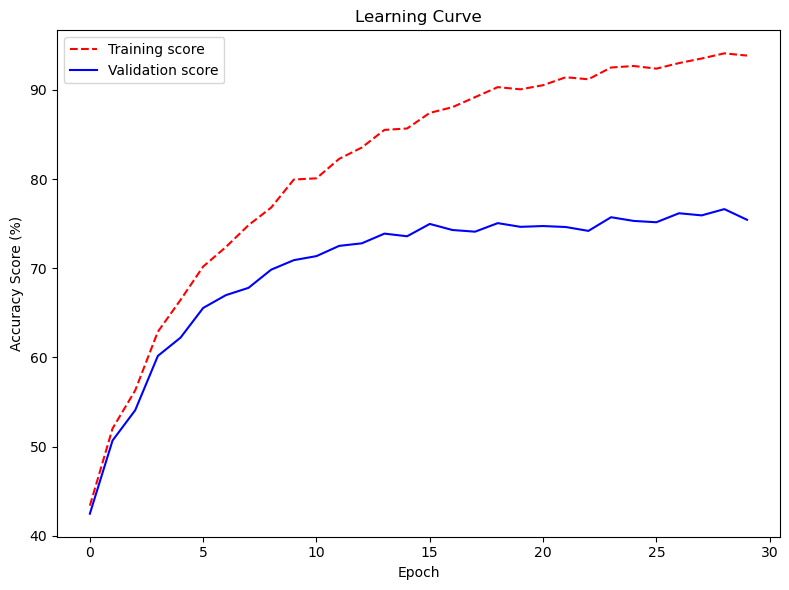

In [25]:
plt.subplots(1, figsize=(8,6))
plt.plot(epochs, train_acc, 'r--', label="Training score")
plt.plot(epochs, val_acc, 'b-', label="Validation score")
plt.title("Learning Curve")
plt.xlabel("Epoch"), plt.ylabel("Accuracy Score (%)"), plt.legend(loc="best")
plt.tight_layout()
plt.show()
         

From the above plot and comparing to the larger model, we see that changing the number of initial filters from 64 to 16 did not actually change model 
performance much. We have slightly lower training set accuracy and validation set accuracy. 

Based on this, it seems like the filter size of 16 is enough to capture most of the details of the image, and having a larger layer of 64 does not do much to improve perfomance. We also see that we are still overfitting by quite a bit, so this issue remains. 

## Change the number of blocks before downsampling

Next, let's try changing the number of blocks before downsampling. What if we use only one ConvNextBlock? This will make our network smaller, and so it might be too small to properly learn the dataset features.

In [26]:
model = Classifier(16, 4, 1)
model.cuda()

Classifier(
  (stem): Conv2d(3, 16, kernel_size=(1, 1), stride=(1, 1))
  (norm1): LayerNorm((16, 32, 32), eps=1e-05, elementwise_affine=True)
  (layers): Sequential(
    (0): ConvNextBlock(
      (conv1): Conv2d(16, 16, kernel_size=(7, 7), stride=(1, 1), padding=same, groups=16)
      (norm): LayerNorm((16, 32, 32), eps=1e-05, elementwise_affine=True)
      (conv2): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (conv3): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
    )
    (1): Downsampler(
      (norm): LayerNorm((16, 32, 32), eps=1e-05, elementwise_affine=True)
      (downsample): Conv2d(16, 32, kernel_size=(2, 2), stride=(2, 2))
    )
    (2): ConvNextBlock(
      (conv1): Conv2d(32, 32, kernel_size=(7, 7), stride=(1, 1), padding=same, groups=32)
      (norm): LayerNorm((32, 16, 16), eps=1e-05, elementwise_affine=True)
      (conv2): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1))
      (conv3): Conv2d(128, 32, kernel_size=(1, 1), stride=(1, 1))
    )
    (3): Dow

In [27]:
#Select loss function and optimizer 
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)

In [28]:
#train for 30 epochs and save training and validation satistics 
new_train_acc, new_train_loss, new_val_acc, new_val_loss = train_n_epochs(30)

Validate (train) Epoch 0: 100%|██████████| 313/313 [00:07<00:00, 39.87it/s]


Epoch 0: training loss: 1.514, accuracy: 44.701


Validate Epoch 0: 100%|██████████| 79/79 [00:02<00:00, 36.11it/s]


Epoch 0: validation loss: 1.505, accuracy: 45.105


Validate (train) Epoch 1: 100%|██████████| 313/313 [00:07<00:00, 41.81it/s]


Epoch 1: training loss: 1.301, accuracy: 52.756


Validate Epoch 1: 100%|██████████| 79/79 [00:02<00:00, 37.84it/s]


Epoch 1: validation loss: 1.309, accuracy: 51.830


Validate (train) Epoch 2: 100%|██████████| 313/313 [00:06<00:00, 49.34it/s]


Epoch 2: training loss: 1.220, accuracy: 56.525


Validate Epoch 2: 100%|██████████| 79/79 [00:02<00:00, 36.05it/s]


Epoch 2: validation loss: 1.248, accuracy: 55.044


Validate (train) Epoch 3: 100%|██████████| 313/313 [00:06<00:00, 49.39it/s]


Epoch 3: training loss: 1.100, accuracy: 60.511


Validate Epoch 3: 100%|██████████| 79/79 [00:02<00:00, 36.71it/s]


Epoch 3: validation loss: 1.147, accuracy: 58.742


Validate (train) Epoch 4: 100%|██████████| 313/313 [00:06<00:00, 49.71it/s]


Epoch 4: training loss: 0.990, accuracy: 65.173


Validate Epoch 4: 100%|██████████| 79/79 [00:02<00:00, 36.06it/s]


Epoch 4: validation loss: 1.063, accuracy: 62.075


Validate (train) Epoch 5: 100%|██████████| 313/313 [00:07<00:00, 41.50it/s]


Epoch 5: training loss: 0.913, accuracy: 67.836


Validate Epoch 5: 100%|██████████| 79/79 [00:02<00:00, 36.06it/s]


Epoch 5: validation loss: 0.992, accuracy: 64.280


Validate (train) Epoch 6: 100%|██████████| 313/313 [00:06<00:00, 45.48it/s]


Epoch 6: training loss: 0.857, accuracy: 69.783


Validate Epoch 6: 100%|██████████| 79/79 [00:02<00:00, 37.16it/s]


Epoch 6: validation loss: 0.950, accuracy: 66.485


Validate (train) Epoch 7: 100%|██████████| 313/313 [00:07<00:00, 43.06it/s]


Epoch 7: training loss: 0.771, accuracy: 73.051


Validate Epoch 7: 100%|██████████| 79/79 [00:02<00:00, 37.27it/s]


Epoch 7: validation loss: 0.897, accuracy: 68.434


Validate (train) Epoch 8: 100%|██████████| 313/313 [00:06<00:00, 44.83it/s]


Epoch 8: training loss: 0.713, accuracy: 75.212


Validate Epoch 8: 100%|██████████| 79/79 [00:02<00:00, 36.68it/s]


Epoch 8: validation loss: 0.835, accuracy: 70.026


Validate (train) Epoch 9: 100%|██████████| 313/313 [00:07<00:00, 41.21it/s]


Epoch 9: training loss: 0.686, accuracy: 75.976


Validate Epoch 9: 100%|██████████| 79/79 [00:02<00:00, 37.18it/s]


Epoch 9: validation loss: 0.829, accuracy: 70.392


Validate (train) Epoch 10: 100%|██████████| 313/313 [00:07<00:00, 41.26it/s]


Epoch 10: training loss: 0.650, accuracy: 77.211


Validate Epoch 10: 100%|██████████| 79/79 [00:02<00:00, 36.41it/s]


Epoch 10: validation loss: 0.824, accuracy: 71.479


Validate (train) Epoch 11: 100%|██████████| 313/313 [00:06<00:00, 49.25it/s]


Epoch 11: training loss: 0.598, accuracy: 79.405


Validate Epoch 11: 100%|██████████| 79/79 [00:02<00:00, 36.61it/s]


Epoch 11: validation loss: 0.794, accuracy: 72.162


Validate (train) Epoch 12: 100%|██████████| 313/313 [00:06<00:00, 44.90it/s]


Epoch 12: training loss: 0.577, accuracy: 79.730


Validate Epoch 12: 100%|██████████| 79/79 [00:01<00:00, 39.54it/s]


Epoch 12: validation loss: 0.775, accuracy: 72.300


Validate (train) Epoch 13: 100%|██████████| 313/313 [00:06<00:00, 49.35it/s]


Epoch 13: training loss: 0.527, accuracy: 81.420


Validate Epoch 13: 100%|██████████| 79/79 [00:02<00:00, 36.92it/s]


Epoch 13: validation loss: 0.755, accuracy: 74.130


Validate (train) Epoch 14: 100%|██████████| 313/313 [00:07<00:00, 41.08it/s]


Epoch 14: training loss: 0.502, accuracy: 82.169


Validate Epoch 14: 100%|██████████| 79/79 [00:02<00:00, 35.93it/s]


Epoch 14: validation loss: 0.743, accuracy: 74.179


Validate (train) Epoch 15: 100%|██████████| 313/313 [00:07<00:00, 41.11it/s]


Epoch 15: training loss: 0.474, accuracy: 83.317


Validate Epoch 15: 100%|██████████| 79/79 [00:02<00:00, 36.83it/s]


Epoch 15: validation loss: 0.743, accuracy: 74.575


Validate (train) Epoch 16: 100%|██████████| 313/313 [00:06<00:00, 49.47it/s]


Epoch 16: training loss: 0.437, accuracy: 84.819


Validate Epoch 16: 100%|██████████| 79/79 [00:02<00:00, 37.04it/s]


Epoch 16: validation loss: 0.731, accuracy: 74.792


Validate (train) Epoch 17: 100%|██████████| 313/313 [00:06<00:00, 48.85it/s]


Epoch 17: training loss: 0.430, accuracy: 84.947


Validate Epoch 17: 100%|██████████| 79/79 [00:02<00:00, 36.72it/s]


Epoch 17: validation loss: 0.738, accuracy: 74.703


Validate (train) Epoch 18: 100%|██████████| 313/313 [00:07<00:00, 39.94it/s]


Epoch 18: training loss: 0.408, accuracy: 85.591


Validate Epoch 18: 100%|██████████| 79/79 [00:02<00:00, 36.40it/s]


Epoch 18: validation loss: 0.742, accuracy: 74.871


Validate (train) Epoch 19: 100%|██████████| 313/313 [00:07<00:00, 41.24it/s]


Epoch 19: training loss: 0.381, accuracy: 86.614


Validate Epoch 19: 100%|██████████| 79/79 [00:02<00:00, 36.72it/s]


Epoch 19: validation loss: 0.738, accuracy: 75.455


Validate (train) Epoch 20: 100%|██████████| 313/313 [00:07<00:00, 41.18it/s]


Epoch 20: training loss: 0.384, accuracy: 86.532


Validate Epoch 20: 100%|██████████| 79/79 [00:02<00:00, 36.68it/s]


Epoch 20: validation loss: 0.725, accuracy: 75.663


Validate (train) Epoch 21: 100%|██████████| 313/313 [00:07<00:00, 40.23it/s]


Epoch 21: training loss: 0.358, accuracy: 87.640


Validate Epoch 21: 100%|██████████| 79/79 [00:02<00:00, 36.14it/s]


Epoch 21: validation loss: 0.739, accuracy: 75.119


Validate (train) Epoch 22: 100%|██████████| 313/313 [00:06<00:00, 49.20it/s]


Epoch 22: training loss: 0.369, accuracy: 86.878


Validate Epoch 22: 100%|██████████| 79/79 [00:02<00:00, 36.71it/s]


Epoch 22: validation loss: 0.755, accuracy: 75.198


Validate (train) Epoch 23: 100%|██████████| 313/313 [00:07<00:00, 40.85it/s]


Epoch 23: training loss: 0.350, accuracy: 87.652


Validate Epoch 23: 100%|██████████| 79/79 [00:02<00:00, 36.64it/s]


Epoch 23: validation loss: 0.744, accuracy: 75.682


Validate (train) Epoch 24: 100%|██████████| 313/313 [00:07<00:00, 42.09it/s]


Epoch 24: training loss: 0.315, accuracy: 88.913


Validate Epoch 24: 100%|██████████| 79/79 [00:01<00:00, 44.56it/s]


Epoch 24: validation loss: 0.763, accuracy: 75.692


Validate (train) Epoch 25: 100%|██████████| 313/313 [00:07<00:00, 41.46it/s]


Epoch 25: training loss: 0.319, accuracy: 88.773


Validate Epoch 25: 100%|██████████| 79/79 [00:02<00:00, 35.99it/s]


Epoch 25: validation loss: 0.756, accuracy: 75.198


Validate (train) Epoch 26: 100%|██████████| 313/313 [00:06<00:00, 49.25it/s]


Epoch 26: training loss: 0.316, accuracy: 88.733


Validate Epoch 26: 100%|██████████| 79/79 [00:02<00:00, 36.74it/s]


Epoch 26: validation loss: 0.780, accuracy: 75.494


Validate (train) Epoch 27: 100%|██████████| 313/313 [00:07<00:00, 41.62it/s]


Epoch 27: training loss: 0.320, accuracy: 88.551


Validate Epoch 27: 100%|██████████| 79/79 [00:02<00:00, 38.94it/s]


Epoch 27: validation loss: 0.816, accuracy: 74.278


Validate (train) Epoch 28: 100%|██████████| 313/313 [00:06<00:00, 49.60it/s]


Epoch 28: training loss: 0.291, accuracy: 89.729


Validate Epoch 28: 100%|██████████| 79/79 [00:01<00:00, 43.65it/s]


Epoch 28: validation loss: 0.777, accuracy: 75.633


Validate (train) Epoch 29: 100%|██████████| 313/313 [00:06<00:00, 49.18it/s]


Epoch 29: training loss: 0.260, accuracy: 90.800


Validate Epoch 29: 100%|██████████| 79/79 [00:01<00:00, 44.18it/s]

Epoch 29: validation loss: 0.751, accuracy: 76.137


In [29]:
# Wrap our plotting in a function 

def plot_train_val_perf(n_epochs, train_acc, val_acc):
    epochs = [i for i in range(n_epochs)]
    plt.subplots(1, figsize=(8,6))
    plt.plot(epochs, train_acc, 'r--', label="Training score")
    plt.plot(epochs, val_acc, 'b-', label="Validation score")
    plt.title("Learning Curve")
    plt.xlabel("Epoch"), plt.ylabel("Accuracy Score (%)"), plt.legend(loc="best")
    plt.tight_layout()
    plt.show()

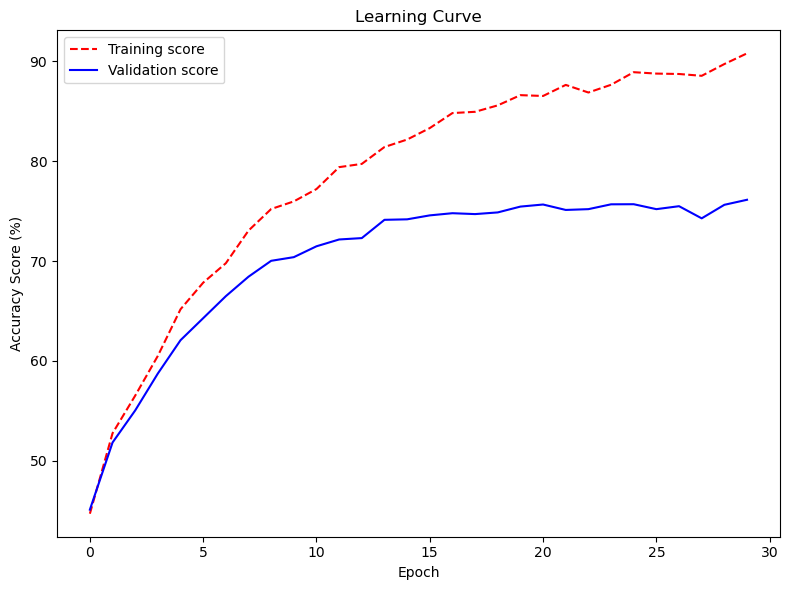

In [30]:
plot_train_val_perf(30, new_train_acc, new_val_acc)

The performance on the training set is a bit lower, which is what we expected could happen. However, the validation accuracy is still similar, and we are still overfitting, so the overall peformance is comparable.

We can also try increasing the number of convolutions before downsampling -> This increases the size of our network, so gives more parameters to tune. However, given that 1 and 2 convolution blocks performed similarly, it's hard to know if more parameters will improve the performance substantially.

In [41]:
model = Classifier(16, 4, 3) #Add an initial Convolution block before downsampling this time.
model.cuda()

Classifier(
  (stem): Conv2d(3, 16, kernel_size=(1, 1), stride=(1, 1))
  (norm1): LayerNorm((16, 32, 32), eps=1e-05, elementwise_affine=True)
  (layers): Sequential(
    (0): ConvNextBlock(
      (conv1): Conv2d(16, 16, kernel_size=(7, 7), stride=(1, 1), padding=same, groups=16)
      (norm): LayerNorm((16, 32, 32), eps=1e-05, elementwise_affine=True)
      (conv2): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (conv3): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
    )
    (1): ConvNextBlock(
      (conv1): Conv2d(16, 16, kernel_size=(7, 7), stride=(1, 1), padding=same, groups=16)
      (norm): LayerNorm((16, 32, 32), eps=1e-05, elementwise_affine=True)
      (conv2): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (conv3): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
    )
    (2): ConvNextBlock(
      (conv1): Conv2d(16, 16, kernel_size=(7, 7), stride=(1, 1), padding=same, groups=16)
      (norm): LayerNorm((16, 32, 32), eps=1e-05, elementwise_affine=True

In [42]:
#Select loss function and optimizer 
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)

In [43]:
conv_train_acc, conv_train_loss, conv_val_acc, conv_val_loss = train_n_epochs(30)

Validate (train) Epoch 0: 100%|██████████| 313/313 [00:07<00:00, 44.31it/s]


Epoch 0: training loss: 1.558, accuracy: 44.599


Validate Epoch 0: 100%|██████████| 79/79 [00:02<00:00, 36.93it/s]


Epoch 0: validation loss: 1.569, accuracy: 43.434


Validate (train) Epoch 1: 100%|██████████| 313/313 [00:06<00:00, 49.42it/s]


Epoch 1: training loss: 1.202, accuracy: 57.313


Validate Epoch 1: 100%|██████████| 79/79 [00:02<00:00, 36.17it/s]


Epoch 1: validation loss: 1.226, accuracy: 56.280


Validate (train) Epoch 2: 100%|██████████| 313/313 [00:06<00:00, 49.57it/s]


Epoch 2: training loss: 1.046, accuracy: 63.541


Validate Epoch 2: 100%|██████████| 79/79 [00:02<00:00, 36.52it/s]


Epoch 2: validation loss: 1.113, accuracy: 60.413


Validate (train) Epoch 3: 100%|██████████| 313/313 [00:06<00:00, 49.09it/s]


Epoch 3: training loss: 0.908, accuracy: 68.485


Validate Epoch 3: 100%|██████████| 79/79 [00:02<00:00, 36.92it/s]


Epoch 3: validation loss: 0.991, accuracy: 64.972


Validate (train) Epoch 4: 100%|██████████| 313/313 [00:07<00:00, 40.95it/s]


Epoch 4: training loss: 0.800, accuracy: 71.882


Validate Epoch 4: 100%|██████████| 79/79 [00:02<00:00, 37.32it/s]


Epoch 4: validation loss: 0.908, accuracy: 67.909


Validate (train) Epoch 5: 100%|██████████| 313/313 [00:06<00:00, 45.78it/s]


Epoch 5: training loss: 0.686, accuracy: 76.463


Validate Epoch 5: 100%|██████████| 79/79 [00:02<00:00, 37.53it/s]


Epoch 5: validation loss: 0.832, accuracy: 71.212


Validate (train) Epoch 6: 100%|██████████| 313/313 [00:07<00:00, 40.89it/s]


Epoch 6: training loss: 0.612, accuracy: 78.789


Validate Epoch 6: 100%|██████████| 79/79 [00:02<00:00, 36.62it/s]


Epoch 6: validation loss: 0.785, accuracy: 72.369


Validate (train) Epoch 7: 100%|██████████| 313/313 [00:06<00:00, 48.28it/s]


Epoch 7: training loss: 0.532, accuracy: 81.677


Validate Epoch 7: 100%|██████████| 79/79 [00:02<00:00, 36.24it/s]


Epoch 7: validation loss: 0.737, accuracy: 73.695


Validate (train) Epoch 8: 100%|██████████| 313/313 [00:07<00:00, 40.42it/s]


Epoch 8: training loss: 0.491, accuracy: 82.980


Validate Epoch 8: 100%|██████████| 79/79 [00:01<00:00, 43.64it/s]


Epoch 8: validation loss: 0.741, accuracy: 73.981


Validate (train) Epoch 9: 100%|██████████| 313/313 [00:07<00:00, 41.42it/s]


Epoch 9: training loss: 0.448, accuracy: 84.627


Validate Epoch 9: 100%|██████████| 79/79 [00:02<00:00, 36.12it/s]


Epoch 9: validation loss: 0.732, accuracy: 74.684


Validate (train) Epoch 10: 100%|██████████| 313/313 [00:06<00:00, 49.00it/s]


Epoch 10: training loss: 0.416, accuracy: 85.573


Validate Epoch 10: 100%|██████████| 79/79 [00:02<00:00, 37.80it/s]


Epoch 10: validation loss: 0.741, accuracy: 74.980


Validate (train) Epoch 11: 100%|██████████| 313/313 [00:06<00:00, 49.60it/s]


Epoch 11: training loss: 0.362, accuracy: 87.617


Validate Epoch 11: 100%|██████████| 79/79 [00:01<00:00, 43.09it/s]


Epoch 11: validation loss: 0.703, accuracy: 75.485


Validate (train) Epoch 12: 100%|██████████| 313/313 [00:07<00:00, 41.86it/s]


Epoch 12: training loss: 0.329, accuracy: 88.708


Validate Epoch 12: 100%|██████████| 79/79 [00:02<00:00, 36.35it/s]


Epoch 12: validation loss: 0.726, accuracy: 76.187


Validate (train) Epoch 13: 100%|██████████| 313/313 [00:06<00:00, 48.97it/s]


Epoch 13: training loss: 0.329, accuracy: 88.501


Validate Epoch 13: 100%|██████████| 79/79 [00:02<00:00, 36.60it/s]


Epoch 13: validation loss: 0.741, accuracy: 75.633


Validate (train) Epoch 14: 100%|██████████| 313/313 [00:06<00:00, 49.23it/s]


Epoch 14: training loss: 0.275, accuracy: 90.430


Validate Epoch 14: 100%|██████████| 79/79 [00:02<00:00, 36.53it/s]


Epoch 14: validation loss: 0.707, accuracy: 76.790


Validate (train) Epoch 15: 100%|██████████| 313/313 [00:06<00:00, 45.63it/s]


Epoch 15: training loss: 0.270, accuracy: 90.652


Validate Epoch 15: 100%|██████████| 79/79 [00:02<00:00, 36.63it/s]


Epoch 15: validation loss: 0.734, accuracy: 76.731


Validate (train) Epoch 16: 100%|██████████| 313/313 [00:06<00:00, 47.22it/s]


Epoch 16: training loss: 0.247, accuracy: 91.316


Validate Epoch 16: 100%|██████████| 79/79 [00:02<00:00, 36.51it/s]


Epoch 16: validation loss: 0.750, accuracy: 76.562


Validate (train) Epoch 17: 100%|██████████| 313/313 [00:06<00:00, 48.88it/s]


Epoch 17: training loss: 0.223, accuracy: 92.160


Validate Epoch 17: 100%|██████████| 79/79 [00:01<00:00, 41.32it/s]


Epoch 17: validation loss: 0.734, accuracy: 77.373


Validate (train) Epoch 18: 100%|██████████| 313/313 [00:06<00:00, 48.40it/s]


Epoch 18: training loss: 0.216, accuracy: 92.407


Validate Epoch 18: 100%|██████████| 79/79 [00:02<00:00, 36.33it/s]


Epoch 18: validation loss: 0.752, accuracy: 77.195


Validate (train) Epoch 19: 100%|██████████| 313/313 [00:06<00:00, 49.40it/s]


Epoch 19: training loss: 0.204, accuracy: 92.911


Validate Epoch 19: 100%|██████████| 79/79 [00:01<00:00, 44.09it/s]


Epoch 19: validation loss: 0.779, accuracy: 76.978


Validate (train) Epoch 20: 100%|██████████| 313/313 [00:07<00:00, 41.34it/s]


Epoch 20: training loss: 0.189, accuracy: 93.376


Validate Epoch 20: 100%|██████████| 79/79 [00:02<00:00, 36.32it/s]


Epoch 20: validation loss: 0.793, accuracy: 77.284


Validate (train) Epoch 21: 100%|██████████| 313/313 [00:07<00:00, 40.67it/s]


Epoch 21: training loss: 0.167, accuracy: 94.229


Validate Epoch 21: 100%|██████████| 79/79 [00:02<00:00, 37.38it/s]


Epoch 21: validation loss: 0.797, accuracy: 76.919


Validate (train) Epoch 22: 100%|██████████| 313/313 [00:07<00:00, 41.81it/s]


Epoch 22: training loss: 0.154, accuracy: 94.741


Validate Epoch 22: 100%|██████████| 79/79 [00:02<00:00, 35.55it/s]


Epoch 22: validation loss: 0.770, accuracy: 77.601


Validate (train) Epoch 23: 100%|██████████| 313/313 [00:06<00:00, 49.93it/s]


Epoch 23: training loss: 0.163, accuracy: 94.332


Validate Epoch 23: 100%|██████████| 79/79 [00:01<00:00, 43.02it/s]


Epoch 23: validation loss: 0.809, accuracy: 77.472


Validate (train) Epoch 24: 100%|██████████| 313/313 [00:06<00:00, 49.49it/s]


Epoch 24: training loss: 0.156, accuracy: 94.501


Validate Epoch 24: 100%|██████████| 79/79 [00:02<00:00, 35.70it/s]


Epoch 24: validation loss: 0.797, accuracy: 78.105


Validate (train) Epoch 25: 100%|██████████| 313/313 [00:07<00:00, 42.54it/s]


Epoch 25: training loss: 0.158, accuracy: 94.391


Validate Epoch 25: 100%|██████████| 79/79 [00:02<00:00, 36.21it/s]


Epoch 25: validation loss: 0.817, accuracy: 77.275


Validate (train) Epoch 26: 100%|██████████| 313/313 [00:06<00:00, 48.37it/s]


Epoch 26: training loss: 0.137, accuracy: 95.213


Validate Epoch 26: 100%|██████████| 79/79 [00:01<00:00, 40.82it/s]


Epoch 26: validation loss: 0.811, accuracy: 77.769


Validate (train) Epoch 27: 100%|██████████| 313/313 [00:06<00:00, 48.80it/s]


Epoch 27: training loss: 0.138, accuracy: 94.956


Validate Epoch 27: 100%|██████████| 79/79 [00:01<00:00, 42.88it/s]


Epoch 27: validation loss: 0.774, accuracy: 78.590


Validate (train) Epoch 28: 100%|██████████| 313/313 [00:06<00:00, 46.07it/s]


Epoch 28: training loss: 0.130, accuracy: 95.330


Validate Epoch 28: 100%|██████████| 79/79 [00:02<00:00, 36.68it/s]


Epoch 28: validation loss: 0.808, accuracy: 78.204


Validate (train) Epoch 29: 100%|██████████| 313/313 [00:07<00:00, 42.21it/s]


Epoch 29: training loss: 0.131, accuracy: 95.495


Validate Epoch 29: 100%|██████████| 79/79 [00:02<00:00, 35.85it/s]

Epoch 29: validation loss: 0.807, accuracy: 77.769


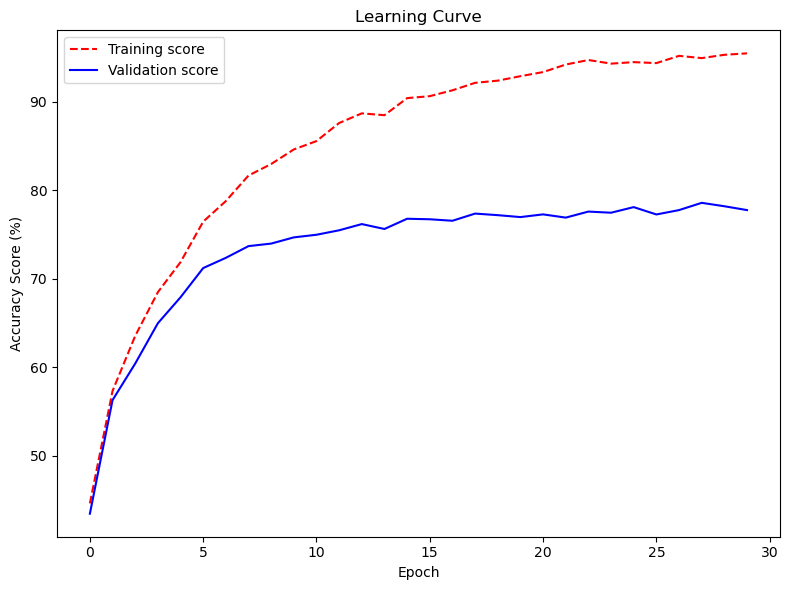

In [44]:
plot_train_val_perf(30, conv_train_acc, conv_val_acc)

This gives us the best performance so far. The training accuracy is noticeably higher than with only 1 Convolution block before downsampling and a slight bit higher than with 2 Convolution blocks, and the validation accuracy is also very slightly higher than the previous two cases as well. It does come at the cost of a larger network, but the training time for 30 epochs is not substantially different, so the slight improvement we see for this data split is probably worth it.

## Modify the initial patching layer

The initial patching layer is set in self.stem in Classifier. Let's try modifying this function to see if we can improve the performance. At the moment, kernel_size and stride are equal, so each part of the image in the patching layer is seen once. Let's try increasing kernel_size to see if it can help model performance. This might help each part of the image be seen more during initialization and training, which could improve performance but might exacerbate overfitting.

In [31]:
from torch import nn


class Downsampler(nn.Module):

    def __init__(self, in_channels, out_channels, shape, stride=2):
        super(Downsampler, self).__init__()

        self.norm = nn.LayerNorm([in_channels, *shape])

        self.downsample = nn.Conv2d(
            in_channels=in_channels, 
            out_channels=out_channels,
            kernel_size = stride,
            stride = stride,
        )
    
    def forward(self, inputs):


        return self.downsample(self.norm(inputs))
        
        

class ConvNextBlock(nn.Module):
    """This block of operations is loosely based on this paper:

    """


    def __init__(self, in_channels, shape):
        super(ConvNextBlock, self).__init__()

        # Depthwise, seperable convolution with a large number of output filters:
        self.conv1 = nn.Conv2d(in_channels=in_channels, 
                                     out_channels=in_channels, 
                                     groups=in_channels,
                                     kernel_size=[7,7],
                                     padding='same' )

        self.norm = nn.LayerNorm([in_channels, *shape])

        # Two more convolutions:
        self.conv2 = nn.Conv2d(in_channels=in_channels, 
                                     out_channels=4*in_channels,
                                     kernel_size=1)

        self.conv3 = nn.Conv2d(in_channels=4*in_channels, 
                                     out_channels=in_channels,
                                     kernel_size=1
                                     )


    def forward(self, inputs):
        x = self.conv1(inputs)

        # The normalization layer:
        x = self.norm(x)

        x = self.conv2(x)

        # The non-linear activation layer:
        x = torch.nn.functional.gelu(x)

        x = self.conv3(x)

        # This makes it a residual network:
        return x + inputs
    

class Classifier(nn.Module):


    def __init__(self, n_initial_filters, n_stages, blocks_per_stage):
        super(Classifier, self).__init__()

        # This is a downsampling convolution that will produce patches of output.

        # This is similar to what vision transformers do to tokenize the images.
        self.stem = nn.Conv2d(in_channels=3,
                                    out_channels=n_initial_filters,
                                    kernel_size=2,
                                    stride=1)
        
        current_shape = [31, 31] #Our initial size changes because of the kernel now being 2 X 2 (H - kh + 1)

        self.norm1 = nn.LayerNorm([n_initial_filters,*current_shape])
        # self.norm1 = WrappedLayerNorm()

        current_n_filters = n_initial_filters
        
        self.layers = nn.Sequential()
        for i, n_blocks in enumerate(range(n_stages)):
            # Add a convnext block series:
            for _ in range(blocks_per_stage):
                self.layers.append(ConvNextBlock(in_channels=current_n_filters, shape=current_shape))
            # Add a downsampling layer:
            if i != n_stages - 1:
                # Skip downsampling if it's the last layer!
                self.layers.append(Downsampler(
                    in_channels=current_n_filters, 
                    out_channels=2*current_n_filters,
                    shape = current_shape,
                    )
                )
                # Double the number of filters:
                current_n_filters = 2*current_n_filters
                # Cut the shape in half:
                current_shape = [ cs // 2 for cs in current_shape]
            


        self.head = nn.Sequential(
            nn.Flatten(),
            nn.LayerNorm(current_n_filters),
            nn.Linear(current_n_filters, 10)
        )
        # self.norm2 = nn.InstanceNorm2d(current_n_filters)
        # # This brings it down to one channel / class
        # self.bottleneck = nn.Conv2d(in_channels=current_n_filters, out_channels=10, 
        #                                   kernel_size=1, stride=1)

    def forward(self, inputs):

        x = self.stem(inputs)
        # Apply a normalization after the initial patching:
        x = self.norm1(x)

        # Apply the main chunk of the network:
        x = self.layers(x)

        # Normalize and readout:
        x = nn.functional.avg_pool2d(x, x.shape[2:])
        x = self.head(x)

        return x



        # x = self.norm2(x)
        # x = self.bottleneck(x)

        # # Average pooling of the remaining spatial dimensions (and reshape) makes this label-like:
        # return nn.functional.avg_pool2d(x, kernel_size=x.shape[-2:]).reshape((-1,10))

In [32]:
model = Classifier(16, 4, 2) #Go back to our base case, but with a different kernel_size.  
model.cuda()

Classifier(
  (stem): Conv2d(3, 16, kernel_size=(2, 2), stride=(1, 1))
  (norm1): LayerNorm((16, 31, 31), eps=1e-05, elementwise_affine=True)
  (layers): Sequential(
    (0): ConvNextBlock(
      (conv1): Conv2d(16, 16, kernel_size=(7, 7), stride=(1, 1), padding=same, groups=16)
      (norm): LayerNorm((16, 31, 31), eps=1e-05, elementwise_affine=True)
      (conv2): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (conv3): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
    )
    (1): ConvNextBlock(
      (conv1): Conv2d(16, 16, kernel_size=(7, 7), stride=(1, 1), padding=same, groups=16)
      (norm): LayerNorm((16, 31, 31), eps=1e-05, elementwise_affine=True)
      (conv2): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (conv3): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
    )
    (2): Downsampler(
      (norm): LayerNorm((16, 31, 31), eps=1e-05, elementwise_affine=True)
      (downsample): Conv2d(16, 32, kernel_size=(2, 2), stride=(2, 2))
    )
    (3): ConvN

In [33]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)

In [34]:
kern_train_acc, kern_train_loss, kern_val_acc, kern_val_loss = train_n_epochs(30)

Validate (train) Epoch 0: 100%|██████████| 313/313 [00:07<00:00, 41.97it/s]


Epoch 0: training loss: 1.548, accuracy: 44.896


Validate Epoch 0: 100%|██████████| 79/79 [00:02<00:00, 33.64it/s]


Epoch 0: validation loss: 1.541, accuracy: 44.858


Validate (train) Epoch 1: 100%|██████████| 313/313 [00:07<00:00, 40.78it/s]


Epoch 1: training loss: 1.343, accuracy: 51.071


Validate Epoch 1: 100%|██████████| 79/79 [00:02<00:00, 35.85it/s]


Epoch 1: validation loss: 1.354, accuracy: 50.178


Validate (train) Epoch 2: 100%|██████████| 313/313 [00:07<00:00, 41.45it/s]


Epoch 2: training loss: 1.141, accuracy: 59.882


Validate Epoch 2: 100%|██████████| 79/79 [00:02<00:00, 36.54it/s]


Epoch 2: validation loss: 1.193, accuracy: 57.644


Validate (train) Epoch 3: 100%|██████████| 313/313 [00:07<00:00, 40.33it/s]


Epoch 3: training loss: 1.023, accuracy: 63.843


Validate Epoch 3: 100%|██████████| 79/79 [00:02<00:00, 36.53it/s]


Epoch 3: validation loss: 1.097, accuracy: 60.502


Validate (train) Epoch 4: 100%|██████████| 313/313 [00:07<00:00, 41.25it/s]


Epoch 4: training loss: 0.925, accuracy: 67.322


Validate Epoch 4: 100%|██████████| 79/79 [00:01<00:00, 41.63it/s]


Epoch 4: validation loss: 1.029, accuracy: 63.252


Validate (train) Epoch 5: 100%|██████████| 313/313 [00:07<00:00, 40.97it/s]


Epoch 5: training loss: 0.872, accuracy: 69.317


Validate Epoch 5: 100%|██████████| 79/79 [00:02<00:00, 36.22it/s]


Epoch 5: validation loss: 0.988, accuracy: 64.784


Validate (train) Epoch 6: 100%|██████████| 313/313 [00:06<00:00, 49.21it/s]


Epoch 6: training loss: 0.787, accuracy: 72.352


Validate Epoch 6: 100%|██████████| 79/79 [00:02<00:00, 38.57it/s]


Epoch 6: validation loss: 0.935, accuracy: 66.752


Validate (train) Epoch 7: 100%|██████████| 313/313 [00:07<00:00, 40.07it/s]


Epoch 7: training loss: 0.752, accuracy: 73.687


Validate Epoch 7: 100%|██████████| 79/79 [00:02<00:00, 36.18it/s]


Epoch 7: validation loss: 0.928, accuracy: 67.277


Validate (train) Epoch 8: 100%|██████████| 313/313 [00:07<00:00, 41.39it/s]


Epoch 8: training loss: 0.691, accuracy: 75.796


Validate Epoch 8: 100%|██████████| 79/79 [00:02<00:00, 36.60it/s]


Epoch 8: validation loss: 0.904, accuracy: 68.315


Validate (train) Epoch 9: 100%|██████████| 313/313 [00:07<00:00, 40.40it/s]


Epoch 9: training loss: 0.594, accuracy: 79.263


Validate Epoch 9: 100%|██████████| 79/79 [00:02<00:00, 35.91it/s]


Epoch 9: validation loss: 0.842, accuracy: 70.530


Validate (train) Epoch 10: 100%|██████████| 313/313 [00:07<00:00, 40.42it/s]


Epoch 10: training loss: 0.548, accuracy: 81.038


Validate Epoch 10: 100%|██████████| 79/79 [00:02<00:00, 36.49it/s]


Epoch 10: validation loss: 0.816, accuracy: 71.766


Validate (train) Epoch 11: 100%|██████████| 313/313 [00:07<00:00, 41.20it/s]


Epoch 11: training loss: 0.528, accuracy: 81.609


Validate Epoch 11: 100%|██████████| 79/79 [00:02<00:00, 36.59it/s]


Epoch 11: validation loss: 0.830, accuracy: 71.618


Validate (train) Epoch 12: 100%|██████████| 313/313 [00:07<00:00, 43.25it/s]


Epoch 12: training loss: 0.471, accuracy: 83.851


Validate Epoch 12: 100%|██████████| 79/79 [00:02<00:00, 36.77it/s]


Epoch 12: validation loss: 0.793, accuracy: 72.458


Validate (train) Epoch 13: 100%|██████████| 313/313 [00:06<00:00, 48.77it/s]


Epoch 13: training loss: 0.468, accuracy: 83.641


Validate Epoch 13: 100%|██████████| 79/79 [00:02<00:00, 36.46it/s]


Epoch 13: validation loss: 0.832, accuracy: 72.112


Validate (train) Epoch 14: 100%|██████████| 313/313 [00:06<00:00, 48.75it/s]


Epoch 14: training loss: 0.412, accuracy: 85.715


Validate Epoch 14: 100%|██████████| 79/79 [00:02<00:00, 36.68it/s]


Epoch 14: validation loss: 0.835, accuracy: 72.646


Validate (train) Epoch 15: 100%|██████████| 313/313 [00:07<00:00, 41.14it/s]


Epoch 15: training loss: 0.365, accuracy: 87.128


Validate Epoch 15: 100%|██████████| 79/79 [00:02<00:00, 36.42it/s]


Epoch 15: validation loss: 0.806, accuracy: 73.269


Validate (train) Epoch 16: 100%|██████████| 313/313 [00:07<00:00, 41.23it/s]


Epoch 16: training loss: 0.358, accuracy: 87.378


Validate Epoch 16: 100%|██████████| 79/79 [00:02<00:00, 36.48it/s]


Epoch 16: validation loss: 0.832, accuracy: 73.764


Validate (train) Epoch 17: 100%|██████████| 313/313 [00:06<00:00, 49.36it/s]


Epoch 17: training loss: 0.329, accuracy: 88.636


Validate Epoch 17: 100%|██████████| 79/79 [00:02<00:00, 36.75it/s]


Epoch 17: validation loss: 0.822, accuracy: 73.675


Validate (train) Epoch 18: 100%|██████████| 313/313 [00:07<00:00, 42.07it/s]


Epoch 18: training loss: 0.301, accuracy: 89.497


Validate Epoch 18: 100%|██████████| 79/79 [00:02<00:00, 36.60it/s]


Epoch 18: validation loss: 0.825, accuracy: 74.110


Validate (train) Epoch 19: 100%|██████████| 313/313 [00:07<00:00, 40.20it/s]


Epoch 19: training loss: 0.290, accuracy: 89.809


Validate Epoch 19: 100%|██████████| 79/79 [00:01<00:00, 45.00it/s]


Epoch 19: validation loss: 0.836, accuracy: 73.714


Validate (train) Epoch 20: 100%|██████████| 313/313 [00:07<00:00, 42.00it/s]


Epoch 20: training loss: 0.298, accuracy: 89.517


Validate Epoch 20: 100%|██████████| 79/79 [00:02<00:00, 36.58it/s]


Epoch 20: validation loss: 0.872, accuracy: 73.299


Validate (train) Epoch 21: 100%|██████████| 313/313 [00:07<00:00, 44.02it/s]


Epoch 21: training loss: 0.276, accuracy: 90.498


Validate Epoch 21: 100%|██████████| 79/79 [00:01<00:00, 44.17it/s]


Epoch 21: validation loss: 0.870, accuracy: 74.120


Validate (train) Epoch 22: 100%|██████████| 313/313 [00:06<00:00, 49.25it/s]


Epoch 22: training loss: 0.253, accuracy: 91.202


Validate Epoch 22: 100%|██████████| 79/79 [00:02<00:00, 37.86it/s]


Epoch 22: validation loss: 0.854, accuracy: 74.436


Validate (train) Epoch 23: 100%|██████████| 313/313 [00:07<00:00, 41.59it/s]


Epoch 23: training loss: 0.250, accuracy: 91.202


Validate Epoch 23: 100%|██████████| 79/79 [00:02<00:00, 36.63it/s]


Epoch 23: validation loss: 0.887, accuracy: 73.962


Validate (train) Epoch 24: 100%|██████████| 313/313 [00:06<00:00, 49.38it/s]


Epoch 24: training loss: 0.244, accuracy: 91.446


Validate Epoch 24: 100%|██████████| 79/79 [00:02<00:00, 36.08it/s]


Epoch 24: validation loss: 0.880, accuracy: 74.258


Validate (train) Epoch 25: 100%|██████████| 313/313 [00:06<00:00, 49.36it/s]


Epoch 25: training loss: 0.215, accuracy: 92.569


Validate Epoch 25: 100%|██████████| 79/79 [00:02<00:00, 38.01it/s]


Epoch 25: validation loss: 0.880, accuracy: 74.377


Validate (train) Epoch 26: 100%|██████████| 313/313 [00:07<00:00, 41.43it/s]


Epoch 26: training loss: 0.197, accuracy: 93.223


Validate Epoch 26: 100%|██████████| 79/79 [00:02<00:00, 38.18it/s]


Epoch 26: validation loss: 0.856, accuracy: 75.376


Validate (train) Epoch 27: 100%|██████████| 313/313 [00:07<00:00, 40.34it/s]


Epoch 27: training loss: 0.205, accuracy: 92.874


Validate Epoch 27: 100%|██████████| 79/79 [00:02<00:00, 36.19it/s]


Epoch 27: validation loss: 0.910, accuracy: 74.486


Validate (train) Epoch 28: 100%|██████████| 313/313 [00:07<00:00, 40.13it/s]


Epoch 28: training loss: 0.206, accuracy: 92.891


Validate Epoch 28: 100%|██████████| 79/79 [00:02<00:00, 36.46it/s]


Epoch 28: validation loss: 0.906, accuracy: 74.585


Validate (train) Epoch 29: 100%|██████████| 313/313 [00:07<00:00, 42.23it/s]


Epoch 29: training loss: 0.183, accuracy: 93.558


Validate Epoch 29: 100%|██████████| 79/79 [00:02<00:00, 35.95it/s]

Epoch 29: validation loss: 0.876, accuracy: 75.287


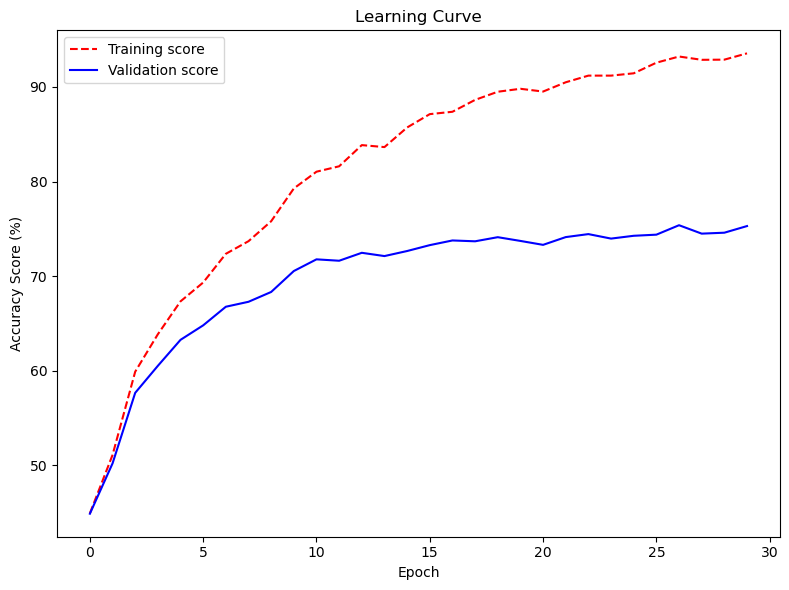

In [35]:
plot_train_val_perf(30, kern_train_acc, kern_val_acc)

Again, the performance is very similar. Good performance on the training set, and slightly worse performance on the validation set.

## Try tuning initial learning rates

One other hyperparameter to tune is the initial learning rate. A too low learning rate would converge/train very slowly, whilst a too high learning rate could plateau at a poorer performance, or even cause divergence. The AdamW optimizer tunes the learning rate itself, but the initial learning rate is still likely to matter for the initial update steps and training trajectory. The literature suggests initial learning rates of ~ 5e-4 (half of our current initial lr), so we will try this next.   

In [37]:
model = Classifier(16, 4, 2) #I re-ran the initial Classifier definition to set kernel size back to 1 
model.cuda()

Classifier(
  (stem): Conv2d(3, 16, kernel_size=(1, 1), stride=(1, 1))
  (norm1): LayerNorm((16, 32, 32), eps=1e-05, elementwise_affine=True)
  (layers): Sequential(
    (0): ConvNextBlock(
      (conv1): Conv2d(16, 16, kernel_size=(7, 7), stride=(1, 1), padding=same, groups=16)
      (norm): LayerNorm((16, 32, 32), eps=1e-05, elementwise_affine=True)
      (conv2): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (conv3): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
    )
    (1): ConvNextBlock(
      (conv1): Conv2d(16, 16, kernel_size=(7, 7), stride=(1, 1), padding=same, groups=16)
      (norm): LayerNorm((16, 32, 32), eps=1e-05, elementwise_affine=True)
      (conv2): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (conv3): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
    )
    (2): Downsampler(
      (norm): LayerNorm((16, 32, 32), eps=1e-05, elementwise_affine=True)
      (downsample): Conv2d(16, 32, kernel_size=(2, 2), stride=(2, 2))
    )
    (3): ConvN

In [38]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0005, weight_decay=0.01) #try a smaller learning rate. 

In [39]:
learn_train_acc, learn_train_loss, learn_val_acc, learn_val_loss = train_n_epochs(30)

Validate (train) Epoch 0: 100%|██████████| 313/313 [00:07<00:00, 40.55it/s]


Epoch 0: training loss: 1.523, accuracy: 44.636


Validate Epoch 0: 100%|██████████| 79/79 [00:02<00:00, 36.13it/s]


Epoch 0: validation loss: 1.526, accuracy: 44.136


Validate (train) Epoch 1: 100%|██████████| 313/313 [00:07<00:00, 42.21it/s]


Epoch 1: training loss: 1.373, accuracy: 50.494


Validate Epoch 1: 100%|██████████| 79/79 [00:02<00:00, 36.53it/s]


Epoch 1: validation loss: 1.387, accuracy: 49.426


Validate (train) Epoch 2: 100%|██████████| 313/313 [00:07<00:00, 41.32it/s]


Epoch 2: training loss: 1.204, accuracy: 57.166


Validate Epoch 2: 100%|██████████| 79/79 [00:01<00:00, 41.89it/s]


Epoch 2: validation loss: 1.228, accuracy: 55.607


Validate (train) Epoch 3: 100%|██████████| 313/313 [00:07<00:00, 41.31it/s]


Epoch 3: training loss: 1.071, accuracy: 62.200


Validate Epoch 3: 100%|██████████| 79/79 [00:02<00:00, 36.26it/s]


Epoch 3: validation loss: 1.126, accuracy: 59.316


Validate (train) Epoch 4: 100%|██████████| 313/313 [00:07<00:00, 40.38it/s]


Epoch 4: training loss: 0.985, accuracy: 65.433


Validate Epoch 4: 100%|██████████| 79/79 [00:02<00:00, 36.47it/s]


Epoch 4: validation loss: 1.056, accuracy: 62.035


Validate (train) Epoch 5: 100%|██████████| 313/313 [00:07<00:00, 41.40it/s]


Epoch 5: training loss: 0.913, accuracy: 68.049


Validate Epoch 5: 100%|██████████| 79/79 [00:02<00:00, 36.01it/s]


Epoch 5: validation loss: 1.013, accuracy: 63.835


Validate (train) Epoch 6: 100%|██████████| 313/313 [00:06<00:00, 49.25it/s]


Epoch 6: training loss: 0.835, accuracy: 71.024


Validate Epoch 6: 100%|██████████| 79/79 [00:02<00:00, 36.35it/s]


Epoch 6: validation loss: 0.959, accuracy: 66.001


Validate (train) Epoch 7: 100%|██████████| 313/313 [00:07<00:00, 40.73it/s]


Epoch 7: training loss: 0.790, accuracy: 72.546


Validate Epoch 7: 100%|██████████| 79/79 [00:02<00:00, 36.43it/s]


Epoch 7: validation loss: 0.919, accuracy: 67.672


Validate (train) Epoch 8: 100%|██████████| 313/313 [00:06<00:00, 49.35it/s]


Epoch 8: training loss: 0.723, accuracy: 74.925


Validate Epoch 8: 100%|██████████| 79/79 [00:02<00:00, 36.22it/s]


Epoch 8: validation loss: 0.881, accuracy: 68.750


Validate (train) Epoch 9: 100%|██████████| 313/313 [00:07<00:00, 44.23it/s]


Epoch 9: training loss: 0.663, accuracy: 76.862


Validate Epoch 9: 100%|██████████| 79/79 [00:02<00:00, 36.66it/s]


Epoch 9: validation loss: 0.841, accuracy: 69.937


Validate (train) Epoch 10: 100%|██████████| 313/313 [00:06<00:00, 45.83it/s]


Epoch 10: training loss: 0.626, accuracy: 78.177


Validate Epoch 10: 100%|██████████| 79/79 [00:02<00:00, 39.17it/s]


Epoch 10: validation loss: 0.853, accuracy: 69.788


Validate (train) Epoch 11: 100%|██████████| 313/313 [00:06<00:00, 49.59it/s]


Epoch 11: training loss: 0.604, accuracy: 78.866


Validate Epoch 11: 100%|██████████| 79/79 [00:02<00:00, 37.74it/s]


Epoch 11: validation loss: 0.867, accuracy: 70.322


Validate (train) Epoch 12: 100%|██████████| 313/313 [00:07<00:00, 43.57it/s]


Epoch 12: training loss: 0.536, accuracy: 81.497


Validate Epoch 12: 100%|██████████| 79/79 [00:01<00:00, 39.81it/s]


Epoch 12: validation loss: 0.814, accuracy: 71.311


Validate (train) Epoch 13: 100%|██████████| 313/313 [00:06<00:00, 46.58it/s]


Epoch 13: training loss: 0.494, accuracy: 83.127


Validate Epoch 13: 100%|██████████| 79/79 [00:02<00:00, 37.69it/s]


Epoch 13: validation loss: 0.805, accuracy: 72.765


Validate (train) Epoch 14: 100%|██████████| 313/313 [00:06<00:00, 48.50it/s]


Epoch 14: training loss: 0.469, accuracy: 83.811


Validate Epoch 14: 100%|██████████| 79/79 [00:02<00:00, 36.47it/s]


Epoch 14: validation loss: 0.793, accuracy: 72.745


Validate (train) Epoch 15: 100%|██████████| 313/313 [00:07<00:00, 40.79it/s]


Epoch 15: training loss: 0.465, accuracy: 83.651


Validate Epoch 15: 100%|██████████| 79/79 [00:02<00:00, 37.68it/s]


Epoch 15: validation loss: 0.834, accuracy: 72.340


Validate (train) Epoch 16: 100%|██████████| 313/313 [00:07<00:00, 42.88it/s]


Epoch 16: training loss: 0.408, accuracy: 85.840


Validate Epoch 16: 100%|██████████| 79/79 [00:02<00:00, 34.87it/s]


Epoch 16: validation loss: 0.815, accuracy: 72.894


Validate (train) Epoch 17: 100%|██████████| 313/313 [00:07<00:00, 39.98it/s]


Epoch 17: training loss: 0.389, accuracy: 86.609


Validate Epoch 17: 100%|██████████| 79/79 [00:02<00:00, 37.88it/s]


Epoch 17: validation loss: 0.803, accuracy: 73.635


Validate (train) Epoch 18: 100%|██████████| 313/313 [00:06<00:00, 49.01it/s]


Epoch 18: training loss: 0.352, accuracy: 87.864


Validate Epoch 18: 100%|██████████| 79/79 [00:02<00:00, 35.78it/s]


Epoch 18: validation loss: 0.800, accuracy: 73.507


Validate (train) Epoch 19: 100%|██████████| 313/313 [00:06<00:00, 48.33it/s]


Epoch 19: training loss: 0.334, accuracy: 88.419


Validate Epoch 19: 100%|██████████| 79/79 [00:02<00:00, 36.22it/s]


Epoch 19: validation loss: 0.816, accuracy: 73.546


Validate (train) Epoch 20: 100%|██████████| 313/313 [00:07<00:00, 44.43it/s]


Epoch 20: training loss: 0.316, accuracy: 89.150


Validate Epoch 20: 100%|██████████| 79/79 [00:02<00:00, 35.82it/s]


Epoch 20: validation loss: 0.820, accuracy: 73.734


Validate (train) Epoch 21: 100%|██████████| 313/313 [00:07<00:00, 41.17it/s]


Epoch 21: training loss: 0.308, accuracy: 89.210


Validate Epoch 21: 100%|██████████| 79/79 [00:02<00:00, 36.23it/s]


Epoch 21: validation loss: 0.841, accuracy: 74.268


Validate (train) Epoch 22: 100%|██████████| 313/313 [00:07<00:00, 40.21it/s]


Epoch 22: training loss: 0.308, accuracy: 89.370


Validate Epoch 22: 100%|██████████| 79/79 [00:02<00:00, 37.31it/s]


Epoch 22: validation loss: 0.867, accuracy: 73.774


Validate (train) Epoch 23: 100%|██████████| 313/313 [00:07<00:00, 40.37it/s]


Epoch 23: training loss: 0.279, accuracy: 90.353


Validate Epoch 23: 100%|██████████| 79/79 [00:01<00:00, 39.58it/s]


Epoch 23: validation loss: 0.863, accuracy: 74.041


Validate (train) Epoch 24: 100%|██████████| 313/313 [00:07<00:00, 40.42it/s]


Epoch 24: training loss: 0.278, accuracy: 90.433


Validate Epoch 24: 100%|██████████| 79/79 [00:02<00:00, 37.57it/s]


Epoch 24: validation loss: 0.883, accuracy: 73.774


Validate (train) Epoch 25: 100%|██████████| 313/313 [00:07<00:00, 41.90it/s]


Epoch 25: training loss: 0.242, accuracy: 91.573


Validate Epoch 25: 100%|██████████| 79/79 [00:02<00:00, 36.11it/s]


Epoch 25: validation loss: 0.874, accuracy: 74.120


Validate (train) Epoch 26: 100%|██████████| 313/313 [00:07<00:00, 40.95it/s]


Epoch 26: training loss: 0.221, accuracy: 92.290


Validate Epoch 26: 100%|██████████| 79/79 [00:02<00:00, 36.44it/s]


Epoch 26: validation loss: 0.844, accuracy: 74.763


Validate (train) Epoch 27: 100%|██████████| 313/313 [00:06<00:00, 48.96it/s]


Epoch 27: training loss: 0.228, accuracy: 92.247


Validate Epoch 27: 100%|██████████| 79/79 [00:02<00:00, 36.46it/s]


Epoch 27: validation loss: 0.913, accuracy: 74.199


Validate (train) Epoch 28: 100%|██████████| 313/313 [00:07<00:00, 41.58it/s]


Epoch 28: training loss: 0.208, accuracy: 92.831


Validate Epoch 28: 100%|██████████| 79/79 [00:02<00:00, 38.52it/s]


Epoch 28: validation loss: 0.877, accuracy: 74.248


Validate (train) Epoch 29: 100%|██████████| 313/313 [00:07<00:00, 41.63it/s]


Epoch 29: training loss: 0.203, accuracy: 92.866


Validate Epoch 29: 100%|██████████| 79/79 [00:02<00:00, 36.41it/s]

Epoch 29: validation loss: 0.902, accuracy: 74.960


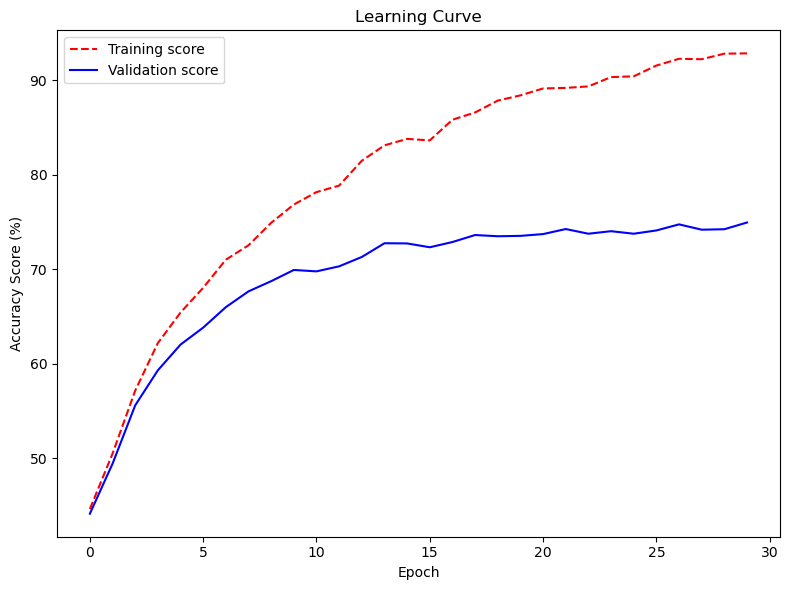

In [40]:
plot_train_val_perf(30, learn_train_acc, learn_val_acc)

We don't really see much difference -> The learning rate tuning as part of the AdamW optimizer means that changing the initial learning rate by a factor of 2 does not really impact training or validation too much.